<a href="https://colab.research.google.com/github/kuantingC/positioning/blob/master/EEG_CNN_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install h5py

In [0]:
# !pip install -U -q PyDrive ## you will have install for every colab session

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # 1. Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# mat_import = drive.CreateFile({'id':'16NbTvbchzCrftTP2iVKbmA2a54fQ4nNV'})
# mat_import.GetContentFile('project_data.zip') # - 'sample.json' is the file name that will be accessible in the notebook
# # print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
# # data = sio.loadmat('sample.mat') # load the .mat file.
# # R = data['R'][0,:]



In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/My Drive/UCLA/EE239AS Deep learning/project/code

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/UCLA/EE239AS Deep learning/project/code


In [5]:
import zipfile
with zipfile.ZipFile("project_data.zip", "r") as zip_ref:
    zip_ref.extractall()


%cd project

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

%cd ..

/content/drive/My Drive/UCLA/EE239AS Deep learning/project/code/project
/content/drive/My Drive/UCLA/EE239AS Deep learning/project/code


In [6]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 25, 1000)
Test data shape: (443, 25, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


## preprocessing

In [0]:
def onehotencoding(y_train_valid):
  num_train = y_train_valid.shape[0]
  num_class = len(np.unique(y_train_valid))
  y_train = np.zeros((num_train, num_class))
  y_train[range(num_train), y_train_valid-769] = 1
  return y_train

Y_train = onehotencoding(y_train_valid)
Y_test = onehotencoding(y_test)

X_train = X_train_valid[:,0:22,:]
X_test = X_test[:,0:22,:]

### show the Fourier transform for a single recording

In [0]:
# plt.plot(2.0/N * np.abs(X_train_freq[0,0,:]))
# X_train_freq[0,0,:].shape
# X_train_freq[0,0,0:N//2].shape

(500,)

In [0]:
X_train_freq = np.fft.rfft(X_train)
X_train_freq.shape
# freqs = np.arange(0,1/2*fs,fs/N)
# plt.plot(freqs, 2.0/N * np.abs(X_train_freq[0,0,0:N//2]))


(2115, 22, 501)

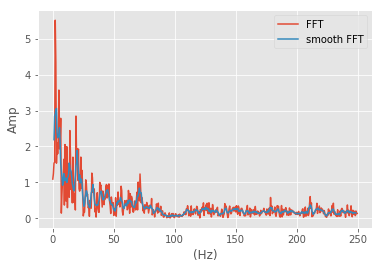

In [0]:
fs = 500
x = np.arange(0,4,1/fs)
y = X_train[0,0,:]
N = len(y)
yf = np.fft.fft(y)
xf = np.arange(0,1/2*fs,fs/N)

def findFFT(X):
  N = X.shape[-1]
  Xf = np.fft.fft(X)

def running_mean(x, N):
  
  cumsum = np.cumsum(np.insert(x, 0, 0)) 
  return (cumsum[N:] - cumsum[:-N]) / N

window = 5
yf_hat = running_mean(2.0 / N * np.abs(yf[0:N//2]), window)


plt.style.use('ggplot')

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax.grid(True)
ax.set(xlabel = '(Hz)', ylabel = 'Amp')
ax.plot(xf[window-3:-window+3], yf_hat)
ax.legend(['FFT','smooth FFT'])


(2115, 22, 1000)


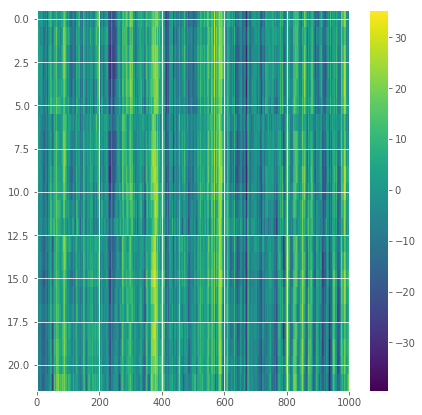

In [0]:
# pd.DataFrame(X_train)
print(X_train.shape)
fig, ax = plt.subplots(figsize = (7,7))
plt.imshow(X_train[0], aspect='auto')
plt.colorbar()

## CNN model

### Trail-wise Deep CNN


### import keras

In [8]:
import keras
from keras.models import Sequential, model_from_json

import keras.backend as K
from keras.layers import *
from keras import regularizers
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


### Without gaussian noise


In [0]:
dropout_rate = 0.3

K.clear_session()
model = Sequential()
model.add(Conv2D(filters=25, kernel_size=(1,10), 
                strides=(1, 1), input_shape=(22,1000,1),
                padding ='valid'))
# model.add(BatchNormalization())
# model.add(GaussianNoise(0.1))
model.add(Conv2D(filters=25, kernel_size=(22,1), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
# model.add(GaussianNoise(0.1))
model.add(SpatialDropout2D(dropout_rate))
model.add(MaxPool2D(pool_size=(1, 3), strides=(1, 3)))
model.add(Reshape((-1,25,1)))
model.add(Conv2D(filters=50, kernel_size=(10,25), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,50,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Conv2D(filters=100, kernel_size=(10,50), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
# model.add(Dropout(dropout_rate))
model.add(SpatialDropout2D(dropout_rate))

model.add(Reshape((-1,100,1)))
model.add(MaxPool2D(pool_size=(2, 1), strides=(2, 1)))
model.add(Conv2D(filters=200, kernel_size=(3,100), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))

model.add(Reshape((-1,200,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Flatten())
# model.add(Dense(units = 20))
# model.add(Activation('elu'))
# model.add(BatchNormalization())
model.add(Dense(units = 4, activation='softmax'))


model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)

history = model.fit(X_train.reshape(-1,22,1000,1), Y_train, 
                    batch_size=256, epochs = 200, validation_split = 0.2,
                    callbacks = [early_stop])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 991, 25)       275       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 991, 25)        13775     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 991, 25)        100       
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 1, 991, 25)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 330, 25)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 330, 25, 1)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 321, 1, 50)       

443/443 [==============================] - 0s 270us/step
training accu is : 97.99%
val accu is : 51.77%
test accu is : 46.28%


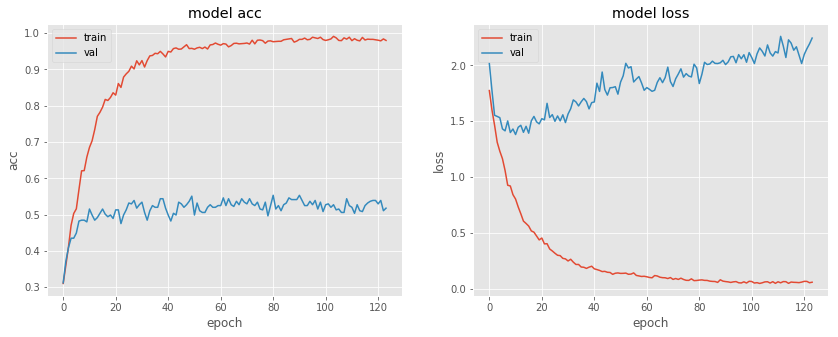

In [0]:
_, accu = model.evaluate(X_test.reshape(-1,22,1000,1), Y_test)

print("training accu is : {:2.2%}".format(history.history['acc'][-1]))
print("val accu is : {:2.2%}".format(history.history['val_acc'][-1]))
print("test accu is : {:2.2%}".format(accu))
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

### With gaussian noise


In [0]:
dropout_rate = 0.6

K.clear_session()
model = Sequential()
model.add(Conv2D(filters=25, kernel_size=(1,10), 
                strides=(1, 1), input_shape=(22,1000,1),
                 activation = 'elu'
                padding ='valid'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.1))
model.add(Conv2D(filters=25, kernel_size=(22,1), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.1))
model.add(SpatialDropout2D(dropout_rate))
model.add(MaxPool2D(pool_size=(1, 3), strides=(1, 3)))
model.add(Reshape((-1,25,1)))
model.add(Conv2D(filters=50, kernel_size=(10,25), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,50,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Conv2D(filters=100, kernel_size=(10,50), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
# model.add(Dropout(dropout_rate))
model.add(SpatialDropout2D(dropout_rate))

model.add(Reshape((-1,100,1)))
model.add(MaxPool2D(pool_size=(2, 1), strides=(2, 1)))
model.add(Conv2D(filters=200, kernel_size=(3,100), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))

model.add(Reshape((-1,200,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Flatten())
# model.add(Dense(units = 20))
# model.add(Activation('elu'))
# model.add(BatchNormalization())
model.add(Dense(units = 4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 991, 25)       275       
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 991, 25)       100       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 22, 991, 25)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 991, 25)        13775     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 991, 25)        100       
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 1, 991, 25)        0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 1, 991, 25)       

In [0]:
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)

history = model.fit(X_train.reshape(2115,22,1000,1), Y_train, 
                    batch_size=256, epochs = 200, validation_split = 0.2,
                    callbacks = [early_stop])



Train on 1692 samples, validate on 423 samples
Epoch 1/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.2121 - acc: 0.2494 - val_loss: 1.5802 - val_acc: 0.2766
Epoch 2/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.9634 - acc: 0.2807 - val_loss: 1.5998 - val_acc: 0.3617
Epoch 3/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.7692 - acc: 0.3061 - val_loss: 1.4532 - val_acc: 0.3688
Epoch 4/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.6821 - acc: 0.3115 - val_loss: 1.3606 - val_acc: 0.3641
Epoch 5/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.6471 - acc: 0.2973 - val_loss: 1.3849 - val_acc: 0.3475
Epoch 6/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.5973 - acc: 0.3109 - val_loss: 1.4247 - val_acc: 0.3759
Epoch 7/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.5543 - acc: 0.3162 - val_loss: 1.3941 - val_acc: 0.3546
Epoch 8/

443/443 [==============================] - 0s 1ms/step
training accu is : 74.29%
val accu is : 48.94%
test accu is : 45.60%


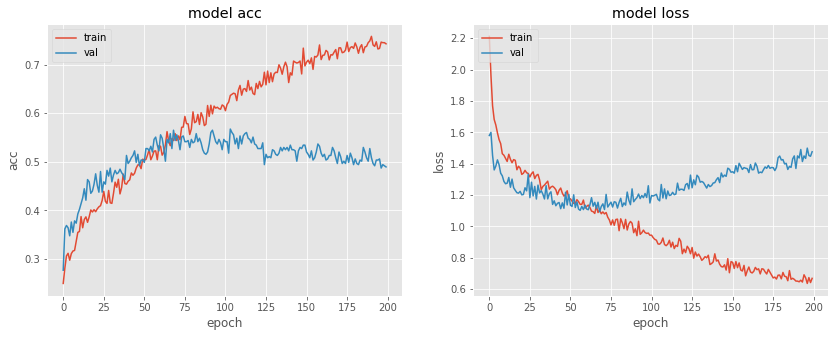

In [0]:
_, accu = model.evaluate(X_test.reshape(-1,22,1000,1), Y_test)

print("training accu is : {:2.2%}".format(history.history['acc'][-1]))
print("val accu is : {:2.2%}".format(history.history['val_acc'][-1]))
print("test accu is : {:2.2%}".format(accu))
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

### Trail-wise Shallow CNN


#### without noise

In [0]:
dropout_rate = 0.6

K.clear_session()
model = Sequential()
model.add(Conv2D(filters=40, kernel_size=(1,25), 
                strides=(1, 1), input_shape=(22,1000,1),
                padding ='valid'))
model.add(BatchNormalization())
# model.add(GaussianNoise(0.1))
model.add(Conv2D(filters=40, kernel_size=(22,1), 
                strides=(1, 1),
                padding ='valid'))
model.add(BatchNormalization())
# model.add(GaussianNoise(0.1))
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,40,1)))
model.add(AveragePooling2D(pool_size=(75,1), strides = (15,1)))
model.add(Flatten())
model.add(Dense(units = 4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])


model.summary()

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7ff2e832c8d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 2199956768


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 976, 40)       1040      
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 976, 40)       160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 976, 40)        35240     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 976, 40)        160       
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 1, 976, 40)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 976, 40, 1)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 61, 40, 1)         0         
__________

In [0]:
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)

history = model.fit(X_train.reshape(2115,22,1000,1), Y_train, 
                    batch_size=256, epochs = 200, validation_split = 0.2,
                    callbacks = [early_stop])


Train on 1692 samples, validate on 423 samples
Epoch 1/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.4535 - acc: 0.2707 - val_loss: 1.3316 - val_acc: 0.3641
Epoch 2/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.3315 - acc: 0.3617 - val_loss: 1.3287 - val_acc: 0.3735
Epoch 3/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.2904 - acc: 0.3859 - val_loss: 1.3103 - val_acc: 0.3877
Epoch 4/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.2677 - acc: 0.4226 - val_loss: 1.2759 - val_acc: 0.3853
Epoch 5/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.2292 - acc: 0.4651 - val_loss: 1.2318 - val_acc: 0.4397
Epoch 6/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.1887 - acc: 0.4752 - val_loss: 1.2246 - val_acc: 0.4303
Epoch 7/200
1692/1692 [==============================] - 2s 1ms/step - loss: 1.1570 - acc: 0.5059 - val_loss: 1.2054 - val_acc: 0.4563
Epoch 8/

443/443 [==============================] - 0s 1ms/step
training accu is : 77.48%
val accu is : 56.74%
test accu is : 59.59%


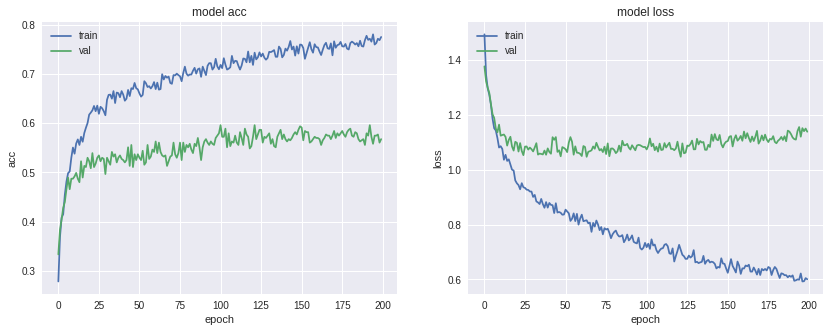

In [0]:
_, accu = model.evaluate(X_test.reshape(-1,22,1000,1), Y_test)

print("training accu is : {:2.2%}".format(history.history['acc'][-1]))
print("val accu is : {:2.2%}".format(history.history['val_acc'][-1]))
print("test accu is : {:2.2%}".format(accu))
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [0]:
dropout_rate = 0.6

K.clear_session()
model2 = Sequential()
model2.add(Conv2D(filters=40, kernel_size=(1,25), 
                strides=(1, 1), input_shape=(22,1000,1),
                padding ='valid'))
model2.add(BatchNormalization())
model2.add(GaussianNoise(0.1))
model2.add(Conv2D(filters=40, kernel_size=(22,1), 
                strides=(1, 1),
                padding ='valid'))
model2.add(BatchNormalization())
model2.add(GaussianNoise(0.1))
model2.add(SpatialDropout2D(dropout_rate))
model2.add(Reshape((-1,40,1)))
model2.add(AveragePooling2D(pool_size=(75,1), strides = (15,1)))
model2.add(Flatten())
model2.add(Dense(units = 4, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])


model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 976, 40)       1040      
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 976, 40)       160       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 22, 976, 40)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 976, 40)        35240     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 976, 40)        160       
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 1, 976, 40)        0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 1, 976, 40)        0         
__________

In [0]:
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)

history2 = model2.fit(X_train.reshape(-1,22,1000,1), Y_train, 
                    batch_size=256, epochs = 200, validation_split = 0.2,
                    callbacks = [early_stop])


Train on 1692 samples, validate on 423 samples
Epoch 1/200
1692/1692 [==============================] - 4s 2ms/step - loss: 1.4681 - acc: 0.2937 - val_loss: 1.3651 - val_acc: 0.3404
Epoch 2/200
1692/1692 [==============================] - 3s 2ms/step - loss: 1.3544 - acc: 0.3511 - val_loss: 1.3408 - val_acc: 0.3735
Epoch 3/200
1692/1692 [==============================] - 3s 2ms/step - loss: 1.2999 - acc: 0.3765 - val_loss: 1.3382 - val_acc: 0.3783
Epoch 4/200
1692/1692 [==============================] - 3s 2ms/step - loss: 1.2883 - acc: 0.4019 - val_loss: 1.2868 - val_acc: 0.3948
Epoch 5/200
1692/1692 [==============================] - 3s 2ms/step - loss: 1.2371 - acc: 0.4498 - val_loss: 1.2466 - val_acc: 0.4657
Epoch 6/200
1692/1692 [==============================] - 3s 2ms/step - loss: 1.1935 - acc: 0.4699 - val_loss: 1.2253 - val_acc: 0.4539
Epoch 7/200
1692/1692 [==============================] - 3s 2ms/step - loss: 1.1554 - acc: 0.4846 - val_loss: 1.1600 - val_acc: 0.4894
Epoch 8/

443/443 [==============================] - 0s 729us/step
training accu is : 76.36%
val accu is : 57.68%
test accu is : 57.34%


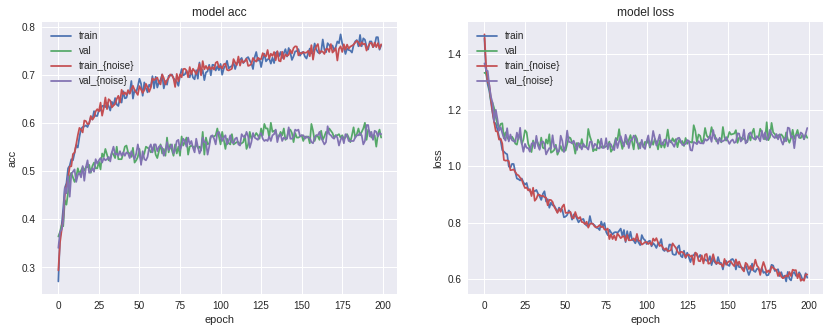

In [0]:
_, accu = model.evaluate(X_test.reshape(-1,22,1000,1), Y_test)

print("training accu is : {:2.2%}".format(history2.history['acc'][-1]))
print("val accu is : {:2.2%}".format(history2.history['val_acc'][-1]))
print("test accu is : {:2.2%}".format(accu))
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val','train_{noise}', 'val_{noise}'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val','train_{noise}', 'val_{noise}'], loc='upper left')

plt.show()

### Data augmentation


In [0]:
def dataargment(X_train, Y_train, window, stride, person_idx):
  num_trail, num_eletrode, num_bin = X_train.shape
  num_class = Y_train.shape[1]
  N = (num_bin - window)//stride+1
  X_train_argment = np.empty((num_trail*N, num_eletrode, window))
  Y_train_argment = np.empty((num_trail*N, num_class))
  person_idx_argment = np.empty(num_trail*N)
  for idx_trail in range(num_trail):
    for n in range(N):
      X_train_argment[idx_trail*N+n,:,:] = X_train[idx_trail,:,n*stride:n*stride+window]
      Y_train_argment[idx_trail*N+n] = Y_train[idx_trail]
      person_idx_argment[idx_trail*N+n] = person_idx[idx_trail]
  return X_train_argment, Y_train_argment, person_idx_argment

def findaccu(y_pred, y_label, window, stride):
  num_trial, num_class = y_label.shape
  N = (1000 - window)//stride+1
  y_label = np.argmax(y_label, axis = 1)
  
  diff = (y_pred - y_label)
  diff = diff.reshape(-1,N)
  result = np.sum(np.count_nonzero(diff, axis = 1) <= np.floor(N//2)) /diff.shape[0]

  return result



window = 750
stride = 25
X_train_argment, Y_train_argment, person_train_idx_argment = dataargment(X_train, Y_train, window, stride,person_train_valid)
X_test_argment, Y_test_argment, person_test_idx_argment = dataargment(X_test, Y_test, window, stride,person_test)


## Deep CNN with data augmentation

In [10]:
dropout_rate = 0.5
l2_reg = 0.001

K.clear_session()
model = Sequential()
model.add(Conv2D(filters=25, kernel_size=(1,10), 
                 strides=(1, 1), input_shape=(22,window,1),
                 activation = 'linear',
                 kernel_regularizer = regularizers.l2(l2_reg),
                 padding ='valid'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.1))
model.add(Conv2D(filters=25, kernel_size=(22,1), 
                strides=(1, 1),
                kernel_regularizer = regularizers.l2(l2_reg),
                padding ='valid')
         )
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(GaussianNoise(0.1))
model.add(SpatialDropout2D(dropout_rate))
model.add(MaxPool2D(pool_size=(1, 3), strides=(1, 3)))
model.add(Reshape((-1,25,1)))
model.add(Conv2D(filters=50, kernel_size=(10,25), 
                strides=(1, 1),
                kernel_regularizer = regularizers.l2(l2_reg),                 
                padding ='valid'))

model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,50,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Conv2D(filters=100, kernel_size=(10,50), 
                strides=(1, 1),
                kernel_regularizer = regularizers.l2(l2_reg),  
                padding ='valid'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,100,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Conv2D(filters=200, kernel_size=(3,100), 
                strides=(1, 1),
                kernel_regularizer = regularizers.l2(l2_reg),
                padding ='valid'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,200,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
# model.add(Flatten())
model.add(Conv2D(filters = 400, kernel_size = (7,200),
                strides = (1,1),
                kernel_regularizer = regularizers.l2(l2_reg),
                 padding = 'valid'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Dropout(dropout_rate))
model.add(Flatten())
model.add(Dense(units = 4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 741, 25)       275       
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 741, 25)       100       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 22, 741, 25)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 741, 25)        13775     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 741, 25)        100       
_________________________________________________________________
activation_1 (Activation)    (None, 1, 741, 25)        0       

In [0]:
from keras.callbacks import ModelCheckpoint


window = 750
stride = 25
X_train_argment, Y_train_argment, person_train_idx_argment = dataargment(X_train, Y_train, window, stride,person_train_valid)
X_test_argment, Y_test_argment, person_test_idx_argment = dataargment(X_test, Y_test, window, stride,person_test)


filepath="weights.best_w_l2_BNafterAct_cnnreplacefc.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1)

history = model.fit(X_train_argment.reshape(-1,22,window,1), Y_train_argment, 
                    batch_size=256, epochs = 500, validation_split = 0.2,
                    callbacks = callbacks_list,
                    verbose = 1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 18612 samples, validate on 4653 samples
Epoch 1/500
18612/18612 [==============================] - 24s 1ms/step - loss: 2.0376 - acc: 0.2562 - val_loss: 1.4760 - val_acc: 0.2734

Epoch 00001: val_acc improved from -inf to 0.27337, saving model to weights.best_w_l2_BNafterAct_cnnreplacefc.hdf5
Epoch 2/500
18612/18612 [==============================] - 19s 997us/step - loss: 1.6025 - acc: 0.2666 - val_loss: 1.4530 - val_acc: 0.3026

Epoch 00002: val_acc improved from 0.27337 to 0.30260, saving model to weights.best_w_l2_BNafterAct_cnnreplacefc.hdf5
Epoch 3/500
18612/18612 [==============================] - 19s 997us/step - loss: 1.5427 - acc: 0.2835 - val_loss: 1.4260 - val_acc: 0.3114

Epoch 00003: val_acc improved from 0.30260 to 0.31141, saving model to weights.best_w_l2_BNafterAct_cnnreplacefc.hdf5
Epoch 4/500
18612/18612 [==============================] - 19s 999us/step - loss: 1.4

In [0]:
"model = keras.models.load_model('weights.best_w_l2_BNafterAct.hdf5')
y_pred = model.predict_classes(X_test_argment.reshape(-1,22,window,1))
print("test_accu is : {:2.2%}".format(findaccu(y_pred, Y_test_argment, window, stride)))


model2 = keras.models.load_model('weights.best_w_l2_stride10.hdf5')
y_pred = model2.predict_classes(X_test_argment.reshape(-1,22,window,1))
print("test_accu is : {:2.2%}".format(findaccu(y_pred, Y_test_argment, window, stride)))


test_accu is : 70.88%
test_accu is : 69.53%


In [0]:
model2 = keras.models.load_model('weights.best_w_l2.hdf5')
y_pred = model2.predict_classes(X_test_argment.reshape(-1,22,window,1))
print("test_accu is : {:2.2%}".format(findaccu(y_pred, Y_test_argment, window, stride)))


test_accu is : 71.11%


In [0]:
model2 = keras.models.load_model('weights.best.hdf5')
y_pred = model2.predict_classes(X_test_argment.reshape(-1,22,window,1))
print("test_accu is : {:2.2%}".format(findaccu(y_pred, Y_test_argment, window, stride)))


test_accu is : 69.53%


In [0]:
|# Majority vote on prediction
X_test_argment, Y_test_argment, person_test_idx_argment = dataargment(X_test, Y_test, window, stride,person_test)


y_pred = model.predict_classes(X_test_argment.reshape(-1,22,window,1))
acc_test = findaccu(y_pred, Y_test_argment, window, stride)
# score, accu = model.evaluate(X_test_argment.reshape(-1,22,window,1), Y_test_argment)
print("best val_accu is : {:2.2%}".format(np.max(history.history['val_acc'])))
print("test_accu is : {:2.2%}".format(acc_test))

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [0]:
from google.colab import files

files.download('model_deep_arg.h5')

In [0]:
num_bin = 1000
window = 750
stride = 25
num_test = Y_test.shape[0]
N = (num_bin - window)//stride+1
y_pred = model.predict_classes(X_test_argment.reshape(-1,22,window,1))
y_pred_trialwise = np.zeros(num_test)
for idx_trial in np.arange(num_test):
# for idx_trial in [128]:
  (values,counts) = np.unique(y_pred[idx_trial:idx_trial+N],return_counts=True)
  ind=np.argmax(counts)
  y_pred_trialwise[idx_trial] = values[ind]
  
np.sum(y_pred_trialwise == np.argmax(Y_test)) / num_test

0.40632054176072235

750

#### Shallow CNN with data argmentation

In [0]:

dropout_rate = 0.6
K.clear_session()
model = Sequential()
model.add(Conv2D(filters=40, kernel_size=(1,25), 
                strides=(1, 1), input_shape=(22,window,1),
                padding ='valid'))
model.add(BatchNormalization())
model.add(Conv2D(filters=40, kernel_size=(22,1), 
                strides=(1, 1),
                padding ='valid'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,40,1)))
model.add(AveragePooling2D(pool_size=(75,1), strides = (15,1)))
model.add(Flatten())
model.add(Dense(units = 4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1)

history = model.fit(X_train_argment.reshape(X_train_argment.shape[0],22,window,1), Y_train_argment, 
                    batch_size=256, epochs = 500, validation_split = 0.2,
                    callbacks = [early_stop], verbose = 0)
print("dropout rate = {} is done.".format(dropout_rate))

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_shallow_arg.h5")
print("Saved model to disk")

Epoch 00167: early stopping


NameError: ignored

In [0]:
X_test.shape

(443, 22, 1000)

2658/2658 [==============================] - 1s 499us/step
training accu is : 48.46%
val accu is : 42.12%
test accu is : 41.38%


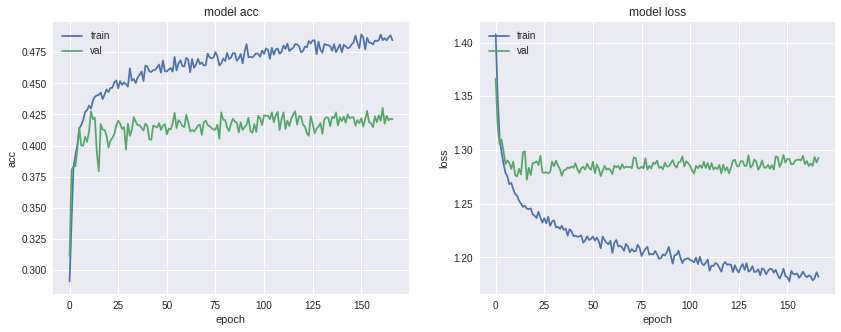

In [0]:
_, accu = model.evaluate(X_test_argment.reshape(-1,22,750,1), Y_test_argment)

print("training accu is : {:2.2%}".format(history.history['acc'][-1]))
print("val accu is : {:2.2%}".format(history.history['val_acc'][-1]))
print("test accu is : {:2.2%}".format(accu))

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [0]:
from google.colab import files

files.download('model_shallow_arg.h5')

## Inter subject comparison

In [0]:
def deepcnn(dropout_rate=0.6):
  K.clear_session()
  model = Sequential()
  model.add(Conv2D(filters=25, kernel_size=(1,10), 
                  strides=(1, 1), input_shape=(22,window,1),
                  padding ='valid'))
  model.add(BatchNormalization())
  model.add(SpatialDropout2D(dropout_rate-0.3))
  model.add(Conv2D(filters=25, kernel_size=(22,1), 
                  strides=(1, 1),
                  padding ='valid', activation = 'elu'))
  model.add(BatchNormalization())
  model.add(SpatialDropout2D(dropout_rate-0.3))
  model.add(MaxPool2D(pool_size=(1, 3), strides=(1, 3)))
  model.add(Reshape((-1,25,1)))
  model.add(Conv2D(filters=50, kernel_size=(10,25), 
                  strides=(1, 1),
                  padding ='valid', activation = 'elu'))
  model.add(BatchNormalization())
  model.add(SpatialDropout2D(dropout_rate))
  model.add(Reshape((-1,50,1)))
  model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
  model.add(Conv2D(filters=100, kernel_size=(10,50), 
                  strides=(1, 1),
                  padding ='valid', activation = 'elu'))
  model.add(BatchNormalization())
  model.add(SpatialDropout2D(dropout_rate))
  model.add(Reshape((-1,100,1)))
  model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
  model.add(Conv2D(filters=200, kernel_size=(3,100), 
                  strides=(1, 1),
                  padding ='valid', activation = 'elu'))
  model.add(BatchNormalization())
  model.add(SpatialDropout2D(dropout_rate))
  model.add(Reshape((-1,200,1)))
  model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
  model.add(Flatten())
  model.add(Dense(units = 4, activation='softmax'))

  myadam = keras.optimizers.Adam(lr=0.001, beta_1=0.95, beta_2=0.9999, epsilon=None, decay=0.0, amsgrad=False)

  model.compile(loss='categorical_crossentropy',
                optimizer = myadam,
                metrics = ['accuracy'])

  # model.summary()
  return model

def shallowcnn(dropout_rate=0.5):
  K.clear_session()
  model = Sequential()
  model.add(Conv2D(filters=40, kernel_size=(1,25), 
                  strides=(1, 1), input_shape=(22,window,1),
                  padding ='valid'))
  model.add(BatchNormalization())
  model.add(SpatialDropout2D(dropout_rate-0.3))
  model.add(Conv2D(filters=40, kernel_size=(22,1), 
                  strides=(1, 1),
                  padding ='valid'))
  model.add(BatchNormalization())
  model.add(SpatialDropout2D(dropout_rate))
  model.add(Reshape((-1,40,1)))
  model.add(AveragePooling2D(pool_size=(75,1), strides = (15,1)))
  model.add(Flatten())
  model.add(Dense(units = 4, activation='softmax'))
  model.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])
  return model


## intra-subject variability


In [0]:
dropout_rate = 0.6

K.clear_session()
model = Sequential()
model.add(Conv2D(filters=25, kernel_size=(1,10), 
                strides=(1, 1), input_shape=(22,window,1),
                padding ='valid'))
# model.add(BatchNormalization())
# model.add(GaussianNoise(0.1))
model.add(Conv2D(filters=25, kernel_size=(22,1), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
# model.add(BatchNormalization())
# model.add(GaussianNoise(0.1))
model.add(SpatialDropout2D(dropout_rate))
model.add(MaxPool2D(pool_size=(1, 3), strides=(1, 3)))
model.add(Reshape((-1,25,1)))
model.add(Conv2D(filters=50, kernel_size=(10,25), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
# model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,50,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Conv2D(filters=100, kernel_size=(10,50), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
# model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,100,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Conv2D(filters=200, kernel_size=(3,100), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
# model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,200,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Flatten())
# model.add(Dense(units = 20))
# model.add(Activation('elu'))
# model.add(BatchNormalization())
model.add(Dense(units = 4, activation='softmax'))

myadam = keras.optimizers.Adam(lr=0.001, beta_1=0.95, beta_2=0.9999, epsilon=None, decay=0.0, amsgrad=False)


model.compile(loss='categorical_crossentropy',
              optimizer = myadam,
              metrics = ['accuracy'])

# model.summary()

early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1)

history = model.fit(X_train_argment.reshape(-1,22,window,1), Y_train_argment, 
                    batch_size=256, epochs = 500, validation_split = 0.2,
                    callbacks = [early_stop], verbose = 1)

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_deep_arg_wo_bn.h5")
print("Saved model to disk")

Train on 10152 samples, validate on 2538 samples
Epoch 1/500
10152/10152 [==============================] - 6s 597us/step - loss: 1.3953 - acc: 0.2673 - val_loss: 1.3734 - val_acc: 0.3006
Epoch 2/500
10152/10152 [==============================] - 5s 520us/step - loss: 1.3801 - acc: 0.2948 - val_loss: 1.3428 - val_acc: 0.3629
Epoch 3/500
10152/10152 [==============================] - 5s 519us/step - loss: 1.3792 - acc: 0.3031 - val_loss: 1.3386 - val_acc: 0.3542
Epoch 4/500
10152/10152 [==============================] - 5s 518us/step - loss: 1.3709 - acc: 0.3116 - val_loss: 1.3253 - val_acc: 0.3913
Epoch 5/500
10152/10152 [==============================] - 5s 514us/step - loss: 1.3620 - acc: 0.3324 - val_loss: 1.3226 - val_acc: 0.3779
Epoch 6/500
10152/10152 [==============================] - 5s 511us/step - loss: 1.3591 - acc: 0.3320 - val_loss: 1.2942 - val_acc: 0.4086
Epoch 7/500
10152/10152 [==============================] - 5s 515us/step - loss: 1.3449 - acc: 0.3454 - val_loss: 1.2

OSError: ignored

2658/2658 [==============================] - 1s 320us/step
training accu is : 55.01%
val accu is : 62.61%
test accu is : 60.65%


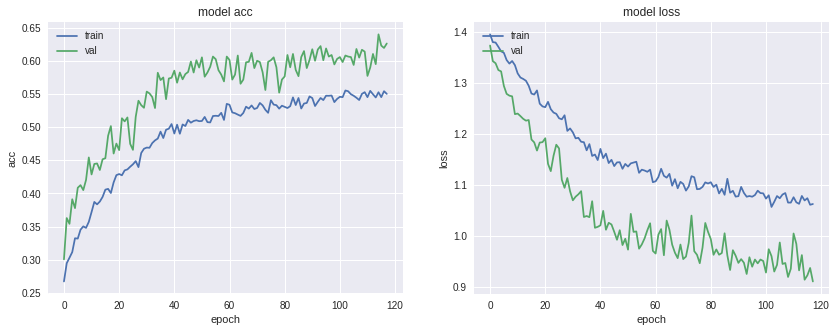

In [0]:
_, accu = model.evaluate(X_test_argment.reshape(-1,22,750,1), Y_test_argment)

print("training accu is : {:2.2%}".format(history.history['acc'][-1]))
print("val accu is : {:2.2%}".format(history.history['val_acc'][-1]))
print("test accu is : {:2.2%}".format(accu))

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

### Train deepcnn on single **subject**

In [0]:
num_subject = np.unique(person_train_valid).shape[0]
cross_subject_accu = np.zeros((num_subject,num_subject))
for num_s in  np.arange(num_subject):
  idx_s_train = np.where(person_train_idx_argment == num_s)[0]
  model_s = deepcnn(0.6)

  early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1)
  num_train = X_train_argment[idx_s_train].shape[0]

  history_s = model_s.fit(X_train_argment[idx_s_train].reshape(num_train,22,window,1),
                          Y_train_argment[idx_s_train], 
                          batch_size=256, epochs = 200, validation_split = 0.2,
                          callbacks = [early_stop], verbose = 1)
  print("Done with one subject")
#   test the accuracy on other subjects
  for num_s_j in np.arange(num_subject):
    idx_s_test = np.where(person_test_idx_argment == num_s_j)[0]
    cross_subject_accu[num_s, num_s_j] = model_s.evaluate(X_test_argment[idx_s_test].reshape(-1,22,window,1), 
                                                          Y_test_argment[idx_s_test])[1]




Train on 1137 samples, validate on 285 samples
Epoch 1/200
1137/1137 [==============================] - 2s 2ms/step - loss: 2.7824 - acc: 0.2515 - val_loss: 1.4646 - val_acc: 0.3719
Epoch 2/200
1137/1137 [==============================] - 1s 982us/step - loss: 2.7087 - acc: 0.2682 - val_loss: 1.9572 - val_acc: 0.2982
Epoch 3/200
1137/1137 [==============================] - 1s 995us/step - loss: 2.5169 - acc: 0.2788 - val_loss: 2.2393 - val_acc: 0.2807
Epoch 4/200
1137/1137 [==============================] - 1s 975us/step - loss: 2.3288 - acc: 0.2797 - val_loss: 2.0002 - val_acc: 0.3018
Epoch 5/200
1137/1137 [==============================] - 1s 984us/step - loss: 2.3277 - acc: 0.2559 - val_loss: 2.0973 - val_acc: 0.3018
Epoch 6/200
1137/1137 [==============================] - 1s 980us/step - loss: 2.1592 - acc: 0.2779 - val_loss: 1.9966 - val_acc: 0.3018
Epoch 7/200
1137/1137 [==============================] - 1s 991us/step - loss: 2.1852 - acc: 0.2806 - val_loss: 2.1265 - val_acc: 0.2

In [0]:
cross_subject_accu

array([[0.59      , 0.34333333, 0.48666667, 0.34333333, 0.20212766,
        0.25170068, 0.38333333, 0.36      , 0.32624113],
       [0.30333333, 0.21      , 0.23666667, 0.25      , 0.30496454,
        0.17346939, 0.23666667, 0.26666667, 0.24113475],
       [0.38666667, 0.27666667, 0.46666667, 0.34      , 0.26950355,
        0.28231293, 0.35333333, 0.30666667, 0.30141844],
       [0.27333333, 0.31666667, 0.2       , 0.31666667, 0.33687943,
        0.30272109, 0.26666667, 0.19333333, 0.20567376],
       [0.22      , 0.26666667, 0.33666667, 0.31333333, 0.35460993,
        0.35034014, 0.31666667, 0.23      , 0.35460993],
       [0.23      , 0.29333333, 0.24333333, 0.22333333, 0.25177305,
        0.22789116, 0.33      , 0.35      , 0.32269504],
       [0.27666667, 0.27333333, 0.31      , 0.34333333, 0.39361702,
        0.28231293, 0.44333333, 0.20333333, 0.26595745],
       [0.29666667, 0.24333333, 0.36333333, 0.16333333, 0.33687943,
        0.24829932, 0.22      , 0.43333333, 0.30851064],


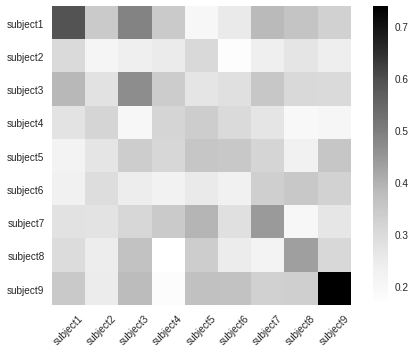

In [0]:
plt.imshow(cross_subject_accu)
plt.grid(False)
subject_id = ['subject1','subject2','subject3','subject4','subject5',
              'subject6','subject7','subject8','subject9']
plt.xticks(range(9), subject_id, rotation='45')
plt.yticks(range(9), subject_id, rotation='0')
plt.colorbar()

# plt.xlabel(subject_id)
# plt.ylabel(subject_id)
# plt.yticks(rotation='vertical')


### Train shallow on single **subject**

In [0]:
num_subject = np.unique(person_train_valid).shape[0]
cross_subject_accu = np.zeros((num_subject,num_subject))
for num_s in  np.arange(num_subject):
  idx_s_train = np.where(person_train_idx_argment == num_s)[0]
  model_s = shallowcnn(0.6)

  early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1)
  num_train = X_train_argment[idx_s_train].shape[0]

  history_s = model_s.fit(X_train_argment[idx_s_train].reshape(num_train,22,window,1),
                          Y_train_argment[idx_s_train], 
                          batch_size=256, epochs = 200, validation_split = 0.2,
                          callbacks = [early_stop], verbose = 1)
  print("Done with one subject")
#   test the accuracy on other subjects
  for num_s_j in np.arange(num_subject):
    idx_s_test = np.where(person_test_idx_argment == num_s_j)[0]
    cross_subject_accu[num_s, num_s_j] = model_s.evaluate(X_test_argment[idx_s_test].reshape(-1,22,window,1), 
                                                          Y_test_argment[idx_s_test])[1]




Train on 1137 samples, validate on 285 samples
Epoch 1/200
1137/1137 [==============================] - 3s 3ms/step - loss: 1.6025 - acc: 0.2586 - val_loss: 1.4088 - val_acc: 0.2737
Epoch 2/200
1137/1137 [==============================] - 2s 2ms/step - loss: 1.4642 - acc: 0.2797 - val_loss: 1.3991 - val_acc: 0.2632
Epoch 3/200
1137/1137 [==============================] - 2s 2ms/step - loss: 1.4149 - acc: 0.2823 - val_loss: 1.3950 - val_acc: 0.2667
Epoch 4/200
1137/1137 [==============================] - 2s 2ms/step - loss: 1.4028 - acc: 0.2885 - val_loss: 1.3828 - val_acc: 0.3123
Epoch 5/200
1137/1137 [==============================] - 2s 2ms/step - loss: 1.3725 - acc: 0.3034 - val_loss: 1.3760 - val_acc: 0.3018
Epoch 6/200
1137/1137 [==============================] - 2s 2ms/step - loss: 1.3696 - acc: 0.3096 - val_loss: 1.3753 - val_acc: 0.2807
Epoch 7/200
1137/1137 [==============================] - 2s 2ms/step - loss: 1.3702 - acc: 0.3210 - val_loss: 1.3730 - val_acc: 0.2877
Epoch 8/

In [0]:
plt.imshow(cross_subject_accu)
plt.grid(False)
subject_id = ['subject1','subject2','subject3','subject4','subject5',
              'subject6','subject7','subject8','subject9']
plt.xticks(range(9), subject_id, rotation='45')
plt.yticks(range(9), subject_id, rotation='0')
plt.colorbar()

# plt.xlabel(subject_id)
# plt.ylabel(subject_id)
# plt.yticks(rotation='vertical')


## Leave one subject out during training

In [0]:
num_subject = np.unique(person_train_valid).shape[0]
cross_subject_accu = np.zeros((num_subject,num_subject))
for num_s in  np.arange(num_subject):
  idx_s_train = np.where(person_train_idx_argment != num_s)[0]
  model_s = deepcnn(0.6)
  early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1)
  num_train = X_train_argment[idx_s_train].shape[0]

  history_s = model_s.fit(X_train_argment[idx_s_train].reshape(num_train,22,window,1),
                          Y_train_argment[idx_s_train], 
                          batch_size=256, epochs = 200, validation_split = 0.2,
                          callbacks = [early_stop], verbose = 1)
  print("Done with one subject")
#   test the accuracy on other subjects
  for num_s_j in np.arange(num_subject):
    idx_s_test = np.where(person_test_idx_argment == num_s_j)[0]
    cross_subject_accu[num_s, num_s_j] = model_s.evaluate(X_test_argment[idx_s_test].reshape(-1,22,window,1), 
                                                          Y_test_argment[idx_s_test])[1]
plt.imshow(cross_subject_accu)
plt.grid(False)
subject_id = ['subject1','subject2','subject3','subject4','subject5',
              'subject6','subject7','subject8','subject9']
plt.title('Leave one subject out')
plt.xticks(range(9), subject_id, rotation='45')
plt.yticks(range(9), subject_id, rotation='0')
plt.colorbar()



## Fine tune with individaul subject before making prediction.

In [0]:
# load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# pretrain_model = model_from_json(loaded_model_json)
# load weights into new model

num_subject = np.unique(person_train_valid).shape[0]
cross_subject_accu = np.zeros((2,num_subject))

for num_s in  np.arange(num_subject):
  idx_s_train = np.where(person_train_idx_argment == num_s)[0]
  num_train = X_train_argment[idx_s_train].shape[0]
  
  
  model_s = keras.models.load_model('weights.best_w_l2.hdf5')
  # load weights into new model
#   pretrain_model = model_from_json(loaded_model_json)
#   pretrain_model.load_weights("model_deep_arg.h5")
  
  early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
  
  model_s.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])
  
  idx_s_test = np.where(person_test_idx_argment == num_s)[0]
  
  y_pred = model_s.predict_classes(X_test_argment[idx_s_test].reshape(-1,22,window,1))

#   cross_subject_accu[0,num_s] = model_s.evaluate(X_test_argment[idx_s_test].reshape(-1,22,window,1), 
#                                                         Y_test_argment[idx_s_test])[1]
  acc_test = findaccu(y_pred, Y_test_argment[idx_s_test], window, stride)
  cross_subject_accu[0,num_s] = acc_test

  # fine tune the model
  model_s.fit(X_train_argment[idx_s_train].reshape(num_train,22,window,1),
                          Y_train_argment[idx_s_train], 
                          batch_size=256, epochs = 30, validation_split = 0.2,
                          verbose = 1)
  y_pred = model_s.predict_classes(X_test_argment[idx_s_test].reshape(-1,22,window,1))
  acc_test = findaccu(y_pred, Y_test_argment[idx_s_test], window, stride)
  cross_subject_accu[1,num_s] = acc_test
  print('complete tuning on {} subject'.format(num_s))


Train on 2085 samples, validate on 522 samples
Epoch 1/30
2085/2085 [==============================] - 10s 5ms/step - loss: 0.7112 - acc: 0.7966 - val_loss: 0.6793 - val_acc: 0.8046
Epoch 2/30
2085/2085 [==============================] - 2s 992us/step - loss: 0.6457 - acc: 0.8177 - val_loss: 0.6319 - val_acc: 0.8276
Epoch 3/30
2085/2085 [==============================] - 2s 992us/step - loss: 0.6145 - acc: 0.8245 - val_loss: 0.6380 - val_acc: 0.8257
Epoch 4/30
2085/2085 [==============================] - 2s 990us/step - loss: 0.5871 - acc: 0.8513 - val_loss: 0.6135 - val_acc: 0.8295
Epoch 5/30
2085/2085 [==============================] - 2s 985us/step - loss: 0.5577 - acc: 0.8614 - val_loss: 0.5992 - val_acc: 0.8352
Epoch 6/30
2085/2085 [==============================] - 2s 988us/step - loss: 0.5256 - acc: 0.8676 - val_loss: 0.5651 - val_acc: 0.8563
Epoch 7/30
2085/2085 [==============================] - 2s 982us/step - loss: 0.4988 - acc: 0.8796 - val_loss: 0.6132 - val_acc: 0.8199
Ep

[[0.76       0.52       0.68       0.62       0.70212766 0.63265306
  0.88       0.66       0.80851064]
 [0.8        0.52       0.8        0.58       0.70212766 0.67346939
  0.84       0.78       0.82978723]]


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


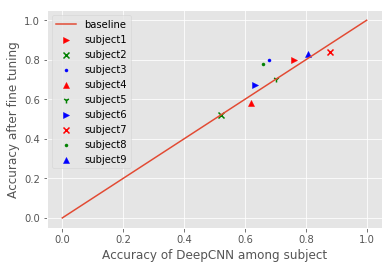

In [0]:
print(cross_subject_accu)
subject_id = ['baseline','subject1', 'subject2', 'subject3', 'subject4', 
              'subject5', 'subject6', 'subject7', 'subject8', 'subject9']
plt.style.use('ggplot')
plt.plot([0,1],[0,1])
marktypes = ['>','x','.','^','1']
colors = ['r','g','b']
for i in np.arange(num_subject):
  plt.scatter(cross_subject_accu[0,i],cross_subject_accu[1,i], 
              marker=marktypes[i%5], color=colors[i%3])
  plt.legend(subject_id)

plt.xlabel('Accuracy of DeepCNN among subject')
plt.ylabel('Accuracy after fine tuning')
ax = plt.axes()

In [0]:
model_s.layers[1].get_weights()[0].shape

(25,)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 741, 25)       275       
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 741, 25)       100       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 22, 741, 25)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 741, 25)        13775     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 741, 25)        100       
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 1, 741, 25)        0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 1, 741, 25)       

In [0]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
pretrain_model = model_from_json(loaded_model_json)
# load weights into new model


num_subject = np.unique(person_train_valid).shape[0]
cross_subject_accu_50 = np.zeros((2,num_subject))

for num_s in  np.arange(num_subject):
  idx_s_train = np.where(person_train_idx_argment == num_s)[0]
  num_train = X_train_argment[idx_s_train].shape[0]

  pretrain_model = model_from_json(loaded_model_json)
  # load weights into new model
  pretrain_model.load_weights("model_deep_arg.h5")
  model_s = pretrain_model
  
  early_stop = EarlyStopping(monitor='loss', patience=15, verbose=1)
  
  model_s.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])
  
  idx_s_test = np.where(person_test_idx_argment == num_s)[0]
  cross_subject_accu_50[0,num_s] = model_s.evaluate(X_test_argment[idx_s_test].reshape(-1,22,window,1), 
                                                        Y_test_argment[idx_s_test])[1]

  # fine tune the model
  model_s.fit(X_train_argment[idx_s_train].reshape(num_train,22,window,1),
                          Y_train_argment[idx_s_train], 
                          batch_size=256, epochs = 50, validation_split = 0.2,
                          verbose = 1)

  cross_subject_accu_50[1,num_s] = model_s.evaluate(X_test_argment[idx_s_test].reshape(-1,22,window,1), 
                                                        Y_test_argment[idx_s_test])[1]


300/300 [==============================] - 6s 19ms/step
Train on 1137 samples, validate on 285 samples
Epoch 1/50
1137/1137 [==============================] - 7s 6ms/step - loss: 0.6718 - acc: 0.7361 - val_loss: 0.4333 - val_acc: 0.8702
Epoch 2/50
1137/1137 [==============================] - 1s 793us/step - loss: 0.6022 - acc: 0.7740 - val_loss: 0.4219 - val_acc: 0.8807
Epoch 3/50
1137/1137 [==============================] - 1s 788us/step - loss: 0.5811 - acc: 0.7643 - val_loss: 0.4072 - val_acc: 0.8702
Epoch 4/50
1137/1137 [==============================] - 1s 806us/step - loss: 0.5615 - acc: 0.7748 - val_loss: 0.3928 - val_acc: 0.8772
Epoch 5/50
1137/1137 [==============================] - 1s 793us/step - loss: 0.5431 - acc: 0.7880 - val_loss: 0.3857 - val_acc: 0.8842
Epoch 6/50
1137/1137 [==============================] - 1s 792us/step - loss: 0.5538 - acc: 0.7757 - val_loss: 0.3864 - val_acc: 0.8877
Epoch 7/50
1137/1137 [==============================] - 1s 794us/step - loss: 0.503

Text(0, 0.5, 'Accuracy after fine tuning')

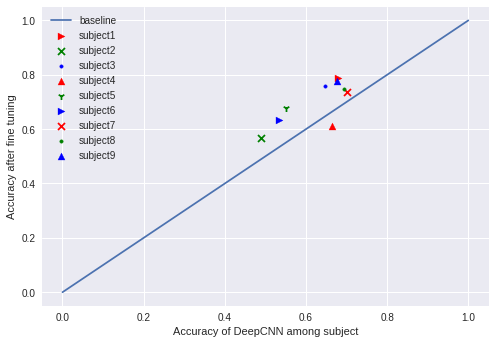

In [0]:
print(cross_subject_accu_50)
subject_id = ['baseline','subject1', 'subject2', 'subject3', 'subject4', 
              'subject5', 'subject6', 'subject7', 'subject8', 'subject9']
plt.plot([0,1],[0,1])
marktypes = ['>','x','.','^','1']
colors = ['r','g','b']
for i in np.arange(num_subject):
  plt.scatter(cross_subject_accu_50[0,i],cross_subject_accu_50[1,i], 
              marker=marktypes[i%5], color=colors[i%3])
  plt.legend(subject_id)

plt.xlabel('Accuracy of DeepCNN among subject')
plt.ylabel('Accuracy after fine tuning')

sample_data/


##RNN model

In [0]:
def vediosegment(X_train, Y_train, window, stride):
  num_trail, num_eletrode, num_bin = X_train.shape
  num_class = Y_train.shape[1]
  N = (num_bin - window)//stride+1
  X_train_argment = np.empty((num_trail, num_eletrode*N, window))
  Y_train_argment = np.empty((num_trail, num_class))
  for idx_trail in range(num_trail):
    for n in range(N):
      X_train_argment[idx_trail*N+n,:,:] = X_train[idx_trail,:,n*stride:n*stride+window]
      Y_train_argment[idx_trail*N+n] = Y_train[idx_trail]
      person_idx_argment[idx_trail*N+n] = person_idx[idx_trail]
  return X_train_argment, Y_train_argment, person_idx_argment

window = 750
stride = 50
X_train_argment, Y_train_argment, person_train_idx_argment = dataargment(X_train, Y_train, window, stride,person_train_valid)
X_test_argment, Y_test_argment, person_test_idx_argment = dataargment(X_test, Y_test, window, stride,person_test)


In [0]:
K.clear_session()

dropout_rate = 0.6
window = 750
K.clear_session()
model = Sequential()
model.add(Conv2D(filters=25, kernel_size=(25,1), 
                strides=(2, 1), input_shape = (750,22,1),
                padding ='valid'))
model.add(MaxPool2D(pool_size = (5,1)))
model.add(Conv2D(filters=25, kernel_size=(2,1), 
                strides=(1, 1),
                padding ='valid'))
model.add(Reshape((-1,25)))
# model.add(LSTM(64,return_sequences = True, 
#                recurrent_dropout = dropout_rate))
model.add(LSTM(16,return_sequences = True, 
               recurrent_dropout = dropout_rate))
model.add(LSTM(8,return_sequences = False, 
               recurrent_dropout = dropout_rate))
# model.add(LSTM(50, return_sequences = True, 
#                recurrent_dropout = dropout_rate))

# model.add(Reshape((-1,50,1)))
# model.add(Conv2D(filters=50, kernel_size=(25,1), 
#                 strides=(25, 1),
#                 padding ='valid'))

# model.add(BatchNormalization())
# model.add(SpatialDropout2D(dropout_rate))
# model.add(GaussianNoise(0.5))
# model.add(Conv2D(filters=50, kernel_size=(5,2), 
#                 strides=(1, 1),
#                 padding ='valid'))
# model.add(BatchNormalization())
# model.add(SpatialDropout2D(dropout_rate))
# model.add(Reshape((-1,25)))

model.add(Dense(4, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics = ['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 363, 22, 25)       650       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 22, 25)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 22, 25)        1275      
_________________________________________________________________
reshape_1 (Reshape)          (None, 1562, 25)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1562, 16)          2688      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
Total para

In [0]:
history = model.fit(X_train_argment.reshape(-1,750,22,1), Y_train_argment, 
                    batch_size=256, epochs = 50, validation_split = 0.2,
                    callbacks = [early_stop], verbose = 1)


Train on 10152 samples, validate on 2538 samples
Epoch 1/50
10152/10152 [==============================] - 273s 27ms/step - loss: 1.4004 - acc: 0.2443 - val_loss: 1.3897 - val_acc: 0.2565
Epoch 2/50
10152/10152 [==============================] - 270s 27ms/step - loss: 1.3863 - acc: 0.2626 - val_loss: 1.3868 - val_acc: 0.2553
Epoch 3/50
10152/10152 [==============================] - 271s 27ms/step - loss: 1.3845 - acc: 0.2642 - val_loss: 1.3869 - val_acc: 0.2620
Epoch 4/50
10152/10152 [==============================] - 270s 27ms/step - loss: 1.3816 - acc: 0.2757 - val_loss: 1.3874 - val_acc: 0.2510
Epoch 5/50
 9984/10152 [============================>.] - ETA: 4s - loss: 1.3787 - acc: 0.2869 

KeyboardInterrupt: ignored

best val_accu is : 63.99%


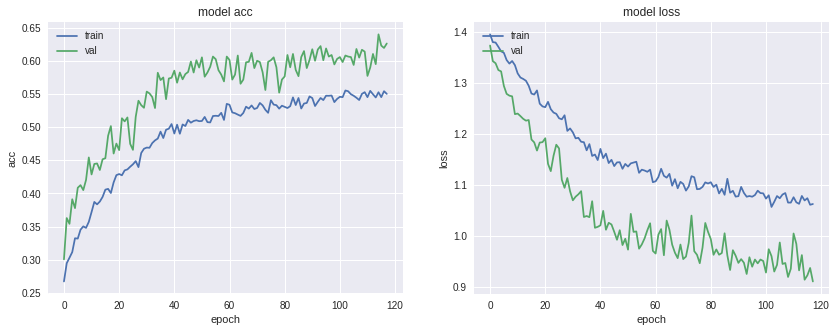

In [0]:
print("best val_accu is : {:2.2%}".format(np.max(history.history['val_acc'])))
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [0]:
K.clear_session()

dropout_rate = 0.8
window = 750
K.clear_session()
model = Sequential()
model.add(LSTM(16, input_shape=(750,22),return_sequences = True, 
               recurrent_dropout = dropout_rate,
               dropout = dropout_rate)
         )

model.add(LSTM(16, return_sequences = True, 
              recurrent_dropout = dropout_rate,
               dropout = dropout_rate)
         )

model.add(Reshape((-1,16,1)))
model.add(Conv2D(filters=25, kernel_size=(10,16), 
                strides=(5, 1),
                padding ='valid'))
model.add(Dense(4, activation = 'relu'))
model.add(Flatten())
model.add(Dense(4, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics = ['accuracy'])
model.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 750, 16)           2496      
_________________________________________________________________
lstm_2 (LSTM)                (None, 750, 16)           2112      
_________________________________________________________________
reshape_1 (Reshape)          (None, 750, 16, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 149, 1, 25)        4025      
_________________________________________________________________
dense_1 (Dense)              (None, 149, 1, 4)         104       
_________________________________________________________________
flatten_1 (Flatten)          (None, 596)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2388      
Total para

In [0]:
history = model.fit(X_train_argment.reshape(-1,750,22), Y_train_argment, 
                    batch_size=256, epochs = 50, validation_split = 0.2,
                    callbacks = [early_stop], verbose = 1)




Train on 10152 samples, validate on 2538 samples
Epoch 1/50
10152/10152 [==============================] - 142s 14ms/step - loss: 1.3873 - acc: 0.2482 - val_loss: 1.3855 - val_acc: 0.2723
Epoch 2/50
10152/10152 [==============================] - 139s 14ms/step - loss: 1.3877 - acc: 0.2529 - val_loss: 1.3858 - val_acc: 0.2723
Epoch 3/50
10152/10152 [==============================] - 139s 14ms/step - loss: 1.3866 - acc: 0.2529 - val_loss: 1.3859 - val_acc: 0.2565
Epoch 4/50
10152/10152 [==============================] - 139s 14ms/step - loss: 1.3870 - acc: 0.2514 - val_loss: 1.3860 - val_acc: 0.2593
Epoch 5/50
10152/10152 [==============================] - 138s 14ms/step - loss: 1.3862 - acc: 0.2522 - val_loss: 1.3860 - val_acc: 0.2585
Epoch 6/50
10152/10152 [==============================] - 138s 14ms/step - loss: 1.3864 - acc: 0.2505 - val_loss: 1.3859 - val_acc: 0.2600
Epoch 7/50
10152/10152 [==============================] - 137s 14ms/step - loss: 1.3858 - acc: 0.2572 - val_loss: 1.3

## Using frequency doamin

In [0]:
def dataargment(X_train, Y_train, window, stride, person_idx):
  num_trail, num_eletrode, num_bin = X_train.shape
  num_class = Y_train.shape[1]
  N = (num_bin - window)//stride+1
  X_train_argment = np.empty((num_trail*N, num_eletrode, window))
  Y_train_argment = np.empty((num_trail*N, num_class))
  person_idx_argment = np.empty(num_trail*N)
  for idx_trail in range(num_trail):
    for n in range(N):
      X_train_argment[idx_trail*N+n,:,:] = X_train[idx_trail,:,n*stride:n*stride+window]
      Y_train_argment[idx_trail*N+n] = Y_train[idx_trail]
      person_idx_argment[idx_trail*N+n] = person_idx[idx_trail]
  return X_train_argment, Y_train_argment, person_idx_argment

window = 200
stride = 200
X_train_argment, Y_train_argment, person_train_idx_argment = dataargment(X_train, Y_train, window, stride,person_train_valid)


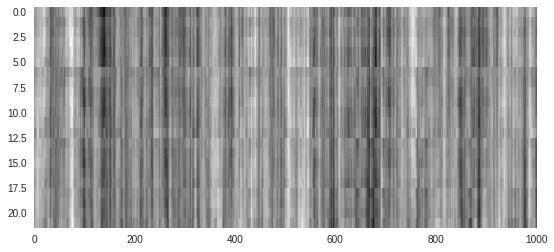

In [0]:
plt.figure(figsize = (9,8))
plt.imshow(X_train[18,:], cmap = 'gray',aspect = 20)
plt.grid(False)

In [0]:
def findpowerspectrum(X):
  N = X[0,0:200].shape[1]
  X_spectrum = 2.0/N * np.abs(np.fft.fft(X))
  return X_spectrum[:,:,0:N//2]
X_spectrum = findpowerspectrum(X_train)

(22, 500)

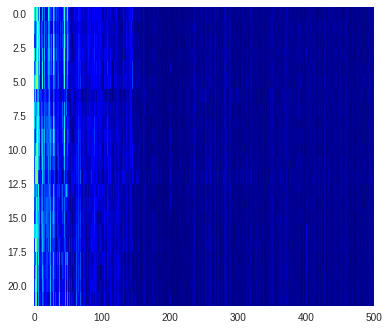

In [0]:
plt.imshow(X_spectrum[55,:],cmap='jet',aspect = 20)
plt.grid(False)
X_spectrum[18,:].shape

In [0]:
X_spectrum.shape

(2115, 25, 500)

In [0]:
windows = [150,300,450,600,750]
row_idx = ['train','val','test']
stride = 50
accu = np.zeros(3,5)
df = pd.DataFrame(accu, columes = windows, index = row_id)
for window in windows:
  X_train_argment, Y_train_argment, person_train_idx_argment = dataargment(X_train, Y_train, window, stride,person_train_valid)
  X_test_augment, Y_test_augment, person_test_idx_argment = dataargment(X_test, Y_test, window, stride,person_test)
  model = deepCNN()
  history = model.fit(X_train_argment.reshape(-1,22,window,1),
                          Y_train_argment[], 
                          batch_size=256, epochs = 200, validation_split = 0.2,
                          callbacks = [early_stop], verbose = 1)
  _, accu = model.evaluate(X_test_augment.reshape(-1,22,window,1), Y_test_augment)
  accu[window,:] = history.history['accu'],  history.history['val_accu'], 

In [0]:
dropout_rate = 0.3
l2_reg = 0.1

K.clear_session()
model = Sequential()
model.add(Conv2D(filters=25, kernel_size=(3,3), 
                 strides=(1, 1), input_shape=(22,501,1),
                 kernel_regularizer = regularizers.l2(l2_reg),
                 padding ='valid'
                )
         )
model.add(BatchNormalization())
# model.add(GaussianNoise(0.1))
model.add(Conv2D(filters=25, kernel_size=(3,3), 
                 strides=(1, 1),
                 kernel_regularizer = regularizers.l2(l2_reg),
                 padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
# model.add(GaussianNoise(0.1))
model.add(SpatialDropout2D(dropout_rate))
model.add(MaxPool2D(pool_size=(1, 3), strides=(1, 3)))
model.add(Reshape((-1,25,1)))
model.add(Conv2D(filters=50, kernel_size=(10,25), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
# model.add(SpatialDropout2D(dropout_rate))
model.add(Reshape((-1,50,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Conv2D(filters=100, kernel_size=(10,50), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
# model.add(Dropout(dropout_rate))
# model.add(SpatialDropout2D(dropout_rate))

model.add(Reshape((-1,100,1)))
model.add(MaxPool2D(pool_size=(2, 1), strides=(2, 1)))
model.add(Conv2D(filters=200, kernel_size=(3,100), 
                strides=(1, 1),
                padding ='valid', activation = 'elu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(dropout_rate))

model.add(Reshape((-1,200,1)))
model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Flatten())
# model.add(Dense(units = 20))
# model.add(Activation('elu'))
# model.add(BatchNormalization())
model.add(Dense(units = 4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)

history = model.fit(X_train_freq.reshape(-1,22,501,1), Y_train, 
                    batch_size=256, epochs = 200, validation_split = 0.2,
                    callbacks = [early_stop])


Train on 1692 samples, validate on 423 samples
Epoch 1/200


/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


1692/1692 [==============================] - 5s 3ms/step - loss: 10.4818 - acc: 0.2441 - val_loss: 13.8645 - val_acc: 0.2506
Epoch 2/200
1692/1692 [==============================] - 4s 2ms/step - loss: 13.0152 - acc: 0.2435 - val_loss: 13.7200 - val_acc: 0.2600
Epoch 3/200
1692/1692 [==============================] - 4s 2ms/step - loss: 13.4105 - acc: 0.2565 - val_loss: 13.8109 - val_acc: 0.2577
Epoch 4/200
1692/1692 [==============================] - 4s 2ms/step - loss: 12.0598 - acc: 0.2553 - val_loss: 12.4934 - val_acc: 0.2459
Epoch 5/200
1692/1692 [==============================] - 4s 2ms/step - loss: 10.9994 - acc: 0.2470 - val_loss: 13.4682 - val_acc: 0.2506
Epoch 6/200
1692/1692 [==============================] - 4s 2ms/step - loss: 10.3540 - acc: 0.2660 - val_loss: 11.0715 - val_acc: 0.2577
Epoch 7/200
1692/1692 [==============================] - 4s 2ms/step - loss: 10.1960 - acc: 0.2530 - val_loss: 10.4152 - val_acc: 0.2506
Epoch 8/200
1692/1692 [==============================

## Treat each recording as a chnnel


In [0]:
dropout_rate = 0.3

K.clear_session()

model = Sequential()
model.add(Conv2D(filters=25, kernel_size=(1,10), 
                strides=(1, 1), input_shape=(1,1000,22),
#                 activation = 'relu',
                padding ='valid'))
# model.add(BatchNormalization())
# model.add(GaussianNoise(0.1))
model.add(Conv2D(filters=25, kernel_size=(1,10), 
                strides=(1, 1),
                padding ='valid', 
                activation = 'relu'))
# model.add(BatchNormalization())
# model.add(GaussianNoise(0.1))
# model.add(SpatialDropout2D(dropout_rate))
model.add(MaxPool2D(pool_size=(1, 2), strides=(1, 2)))

model.add(Conv2D(filters=50, kernel_size=(1,10), 
                strides=(1, 3),
                padding ='valid', 
                activation = 'relu'))

model.add(Conv2D(filters=50, kernel_size=(1,10), 
                strides=(1, 3),
                padding ='valid', 
                activation = 'relu'))

# model.add(Conv2D(filters=50, kernel_size=(1,10), 
#                 strides=(1, 2),
#                 padding ='valid', activation = 'elu'))
# model.add(Conv2D(filters=50, kernel_size=(1,10), 
#                 strides=(1, 2),
#                 padding ='valid', activation = 'elu'))
# model.add(BatchNormalization())
# model.add(SpatialDropout2D(dropout_rate))

# model.add(Conv2D(filters=100, kernel_size=(1,10), 
#                 strides=(1, 2),
#                 padding ='valid', activation = 'elu'))
# model.add(BatchNormalization())
# model.add(SpatialDropout2D(dropout_rate))

# model.add(Reshape((-1,200,1)))
# model.add(MaxPool2D(pool_size=(3, 1), strides=(3, 1)))
model.add(Flatten())
# model.add(Dense(units = 20))
# model.add(Activation('elu'))
# model.add(BatchNormalization())
# model.add(Dense(units = 50, activation='relu', kernel_regularizer =  'l2'))
model.add(Dense(units = 4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 991, 25)        5525      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 982, 25)        6275      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 491, 25)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 161, 50)        12550     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 51, 50)         25050     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2550)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                

In [0]:
early_stop = EarlyStopping(monitor = 'loss',
                           patience = 20)
history = model.fit(X_train.reshape(-1,1,1000,22), Y_train, 
                    batch_size=64, epochs = 200, validation_split = 0.2,
                    callbacks = [early_stop])


Train on 1692 samples, validate on 423 samples
Epoch 1/200
1692/1692 [==============================] - 1s 468us/step - loss: 2.5607 - acc: 0.2595 - val_loss: 1.3852 - val_acc: 0.2837
Epoch 2/200
1692/1692 [==============================] - 0s 235us/step - loss: 1.3660 - acc: 0.3239 - val_loss: 1.3902 - val_acc: 0.2979
Epoch 3/200
1692/1692 [==============================] - 0s 237us/step - loss: 1.2976 - acc: 0.4066 - val_loss: 1.3603 - val_acc: 0.3475
Epoch 4/200
1692/1692 [==============================] - 0s 233us/step - loss: 1.1755 - acc: 0.4835 - val_loss: 1.4222 - val_acc: 0.3144
Epoch 5/200
1692/1692 [==============================] - 0s 233us/step - loss: 0.9839 - acc: 0.5993 - val_loss: 1.4935 - val_acc: 0.2955
Epoch 6/200
1692/1692 [==============================] - 0s 236us/step - loss: 0.7675 - acc: 0.7163 - val_loss: 1.6528 - val_acc: 0.3310
Epoch 7/200
1692/1692 [==============================] - 0s 242us/step - loss: 0.5565 - acc: 0.8233 - val_loss: 1.7211 - val_acc: 0

In [0]:
model.evaluate(X_test.reshape(-1,1,1000,22), Y_test)

443/443 [==============================] - 0s 149us/step


[11.497332301688786, 0.2866817148356082]

#### try data augmentation

In [0]:
from keras import regularizers

K.clear_session()
model = Sequential()
model.add(Conv2D(filters=200, kernel_size=(1,5), 
                 strides=(1, 3), input_shape=(1,1000,22),
                 activation = 'relu', 
                 kernel_regularizer = regularizers.l2(0.1),
                 padding ='valid'
                )
         )
# model.add(BatchNormalization(axis = -1))
model.add(Conv2D(filters=200, kernel_size=(1,5), 
                 strides=(1, 3),
                 activation = 'relu', 
                 kernel_regularizer = regularizers.l2(0.1),
                 padding ='valid'
                )
         )

model.add(MaxPool2D(strides = (1,3), pool_size = (1,3)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# model.add(Conv2D(filters=200, kernel_size=(1,2), 
#                  strides=(1, 2),
#                  activation = 'relu', 
#                  kernel_regularizer = regularizers.l2(0.1),
#                  padding ='valid'
#                 )
#          )
# model.add(Dropout(0.3))

# keras.regularizers.l2
model.add(Flatten())
# model.add(Dense(units = 20))
# model.add(Activation('elu'))
# model.add(BatchNormalization())
model.add(Dense(units = 64, activation='relu', 
                kernel_regularizer = regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units = 4, activation='softmax',
               kernel_regularizer = regularizers.l2(0.1)))

model.compile(loss='kullback_leibler_divergence',
              optimizer = 'adam',
              metrics = ['accuracy'])


model.summary()

early_stop = EarlyStopping(monitor = 'loss',
                           patience = 20)

X_train_ = np.transpose(X_train, axes = (0,2,1))
X_train_ = X_train_.reshape(-1,1,1000,22)


history = model.fit(X_train_, Y_train, 
                    batch_size=128, epochs = 300, validation_split = 0.2, 
                    verbose = 1, callbacks = [early_stop])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 332, 200)       22200     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 110, 200)       200200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 36, 200)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 36, 200)        800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 36, 200)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

443/443 [==============================] - 0s 202us/step
training accu is : 87.23%
val accu is : 43.74%
test accu is : 40.63%


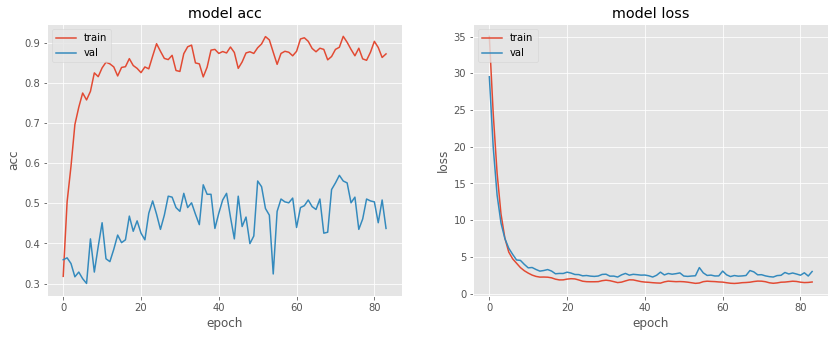

In [0]:
X_test_ = np.transpose(X_test, axes = (0,2,1))
X_test_ = X_test_.reshape(-1,1,1000,22)


_, accu = model.evaluate(X_test_, Y_test)

print("training accu is : {:2.2%}".format(history.history['acc'][-1]))
print("val accu is : {:2.2%}".format(history.history['val_acc'][-1]))
print("test accu is : {:2.2%}".format(accu))
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

### data augmentaion

In [0]:
X_train_augment_ = np.transpose(X_train_argment, axes = (0,2,1))
X_train_augment_ = X_train_augment_.reshape(-1,1,750,22)

X_test_augment_ = np.transpose(X_test_argment, axes = (0,2,1))
X_test_augment_ = X_test_augment_.reshape(-1,1,750,22)


In [0]:
from keras import regularizers
l2_lambda = 0.1
dropout_rate = 0.3
K.clear_session()
model = Sequential()
model.add(Conv2D(filters=100, kernel_size=(1,5), 
                 strides=(1, 3), input_shape=(1,750,22),
#                  activation = 'relu', 
                 kernel_regularizer = regularizers.l2(l2_lambda),
                 padding ='valid'
                )
         )

model.add(Conv2D(filters=100, kernel_size=(1,5), 
                 strides=(1, 3),
                 activation = 'relu', 
                 kernel_regularizer = regularizers.l2(l2_lambda),
                 padding ='valid'
                )
         )
model.add(BatchNormalization())
# model.add(MaxPool2D(strides = (1,3), pool_size = (1,3)))
model.add(Dropout(dropout_rate))
model.add(Conv2D(filters=200, kernel_size=(1,2), 
                 strides=(1, 2),
                 activation = 'relu', 
                 kernel_regularizer = regularizers.l2(l2_lambda),
                 padding ='valid'
                )
         )

model.add(Conv2D(filters=200, kernel_size=(1,1), 
                 strides=(1, 1),
                 activation = 'relu', 
                 kernel_regularizer = regularizers.l2(l2_lambda),
                 padding ='valid'
                )
         )
model.add(BatchNormalization())
# model.add(MaxPool2D(strides = (1,3), pool_size = (1,3)))
model.add(Dropout(dropout_rate))

# keras.regularizers.l2
model.add(Flatten())
# model.add(Dense(units = 20))
# model.add(Activation('elu'))
# model.add(Dense(units = 50, activation='relu', kernel_regularizer =  'l2'))
model.add(Dense(units = 4, activation='softmax',
               kernel_regularizer = regularizers.l2(l2_lambda)))

model.compile(loss='categorical_crossentropy',
              optimizer = 'RMSprop',
              metrics = ['accuracy'])


model.summary()

early_stop = EarlyStopping(monitor = 'loss',
                           patience = 20)


history = model.fit(X_train_augment_, Y_train_argment, 
                    batch_size=64*4, epochs = 300, 
                    validation_split = 0.2, 
                    callbacks = [early_stop],
                    verbose = 1, 
                   )


Using TensorFlow backend.


NameError: ignored

2658/2658 [==============================] - 1s 231us/step
training accu is : 60.70%
val accu is : 43.18%
test accu is : 39.35%


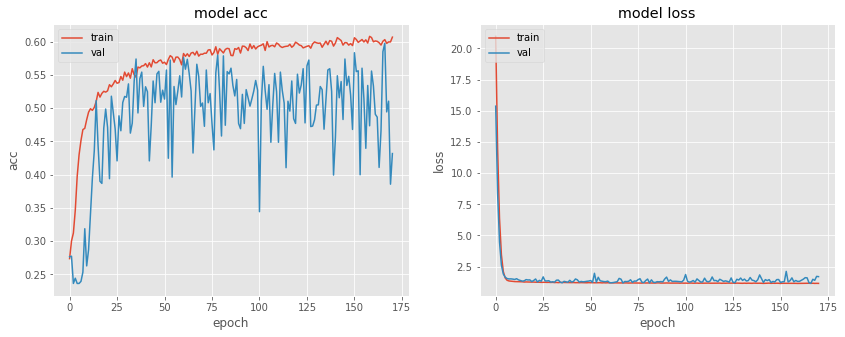

In [0]:
X_test_augment_ = np.transpose(X_test_argment, axes = (0,2,1))
X_test_augment_ = X_test_augment_.reshape(-1,1,750,22)


_, accu = model.evaluate(X_test_augment_, Y_test_argment)

print("training accu is : {:2.2%}".format(history.history['acc'][-1]))
print("val accu is : {:2.2%}".format(history.history['val_acc'][-1]))
print("test accu is : {:2.2%}".format(accu))

plt.style.use('ggplot')
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [0]:
X_train_augment_.shape

(12690, 1, 750, 22)

### Hyperparameter search by talos


In [0]:
!pip install talos


     |████████████████████████████████| 51kB 23.3MB/s 
     |████████████████████████████████| 26.6MB 46.3MB/s 
     |████████████████████████████████| 788kB 30.1MB/s 
     |████████████████████████████████| 12.6MB 16.5MB/s 
  Created wheel for talos: filename=talos-0.6.3-cp36-none-any.whl size=49626 sha256=e476c403883b2993717c4ab761d2a7cfac57ad5a6da6ad8f45054fb6eaefb3b2
  Stored in directory: /root/.cache/pip/wheels/bb/d7/6b/86fd8b1fc7cfbd2c54796412f86efb5fb6a3a5c734014f6a66
  Created wheel for wrangle: filename=wrangle-0.6.7-cp36-none-any.whl size=49894 sha256=eaab0082f6aedb5c565da94d6113df66c717cab95a4aab55502d37b41e1936c1
  Stored in directory: /root/.cache/pip/wheels/bf/1b/50/d0403ce6ef269e364894da7b50db68db14c4ac62c577561e2d
  Created wheel for astetik: filename=astetik-1.9.9-cp36-none-any.whl size=56960 sha256=86f81087d50d9f87f87465bd5b0e747d41a50c116c2dfd83bab41645ff02acd9
  Stored in directory: /root/.cache/pip/wheels/ae/70/21/c475cd079ec401dd6e1b9b1d42b4c38554ce12679bfb214aad

In [0]:
import talos as ta

In [0]:
def EEG_model(x_train, y_train, x_val, y_val, params):

    
    l2_lambda = params['l2_lambda']
    dropout_rate = params['dropout']
    
    model = Sequential()
    model.add(Conv2D(filters=100, kernel_size=(1,5), 
                     strides=(1, 3), input_shape=(1,750,22),
    #                  activation = 'relu', 
                     kernel_regularizer = regularizers.l2(l2_lambda),
                     padding ='valid'
                    )
             )

    model.add(Conv2D(filters=100, kernel_size=(1,5), 
                     strides=(1, 3),
                     activation = params['activation'],
                     kernel_regularizer = regularizers.l2(l2_lambda),
                     padding ='valid'
                    )
             )
    model.add(BatchNormalization())
    # model.add(MaxPool2D(strides = (1,3), pool_size = (1,3)))
    model.add(Dropout(dropout_rate))
    model.add(Conv2D(filters=200, kernel_size=(1,2), 
                     strides=(1, 2),
                     activation = params['activation'],
                     kernel_regularizer = regularizers.l2(l2_lambda),
                     padding ='valid'
                    )
             )

    model.add(Conv2D(filters=200, kernel_size=(1,1), 
                     strides=(1, 1),
                     activation = params['activation'], 
                     kernel_regularizer = regularizers.l2(l2_lambda),
                     padding ='valid'
                    )
             )
    model.add(BatchNormalization())
    model.add(MaxPool2D(strides = (1,3), pool_size = (1,3)))
    model.add(Dropout(dropout_rate))

    # keras.regularizers.l2
    model.add(Flatten())
    # model.add(Dense(units = 20))
    # model.add(Activation('elu'))
    # model.add(Dense(units = 50, activation='relu', kernel_regularizer =  'l2'))
    model.add(Dense(units = 4, activation='softmax',
                   kernel_regularizer = regularizers.l2(l2_lambda)))

    model.compile(loss='categorical_crossentropy',
                  optimizer = params['optimizer'],
                  metrics = ['accuracy'])


#     model.summary()

    early_stop = EarlyStopping(monitor = 'loss',
                               patience = 20)


    history = model.fit(X_train_augment_, Y_train_argment, 
                        batch_size=params['batch_size'], epochs = 300, 
                        validation_split = 0.2, 
                        callbacks = [early_stop],
                        verbose = 1, 
                       )


    
    return history, model

In [0]:
p = {'l2_lambda': (0.01, 0.05, 0.25),
     'batch_size': (64, 128, 256),
     'dropout': (0.1, 0.2, 0.3),
     'optimizer': ['Adam', 'RMSprop'],
     'activation':['relu', 'elu']}

In [0]:
t = ta.Scan(x=X_train_augment_,
            y=Y_train_argment,
            model=EEG_model,
            params=p,
            grid_downsample=0.1,
            experiment_name = 'EEG_test'
            )







  0%|          | 0/256 [00:00<?, ?it/s]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 6s 590us/step - loss: 6.0508 - acc: 0.2901 - val_loss: 5.1990 - val_acc: 0.3077
Epoch 2/300
10152/10152 [==============================] - 5s 448us/step - loss: 4.3283 - acc: 0.3563 - val_loss: 3.6661 - val_acc: 0.3483
Epoch 3/300
10152/10152 [==============================] - 5s 453us/step - loss: 3.1694 - acc: 0.4329 - val_loss: 2.7996 - val_acc: 0.3905
Epoch 4/300
10152/10152 [==============================] - 5s 445us/step - loss: 2.4136 - acc: 0.5030 - val_loss: 2.2868 - val_acc: 0.4283
Epoch 5/300
10152/10152 [==============================] - 5s 454us/step - loss: 1.9808 - acc: 0.5429 - val_loss: 2.2718 - val_acc: 0.4362
Epoch 6/300
10152/10152 [==============================] - 5s 446us/step - loss: 1.6739 - acc: 0.5758 - val_loss: 2.0677 - val_acc: 0.4035
Epoch 7/300
10152/10152 [==============================] - 5s 451us/step - loss: 1.4899 - acc: 0.5937 - val_loss: 1.7






  0%|          | 1/256 [09:28<40:16:52, 568.68s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 507us/step - loss: 5.9652 - acc: 0.2803 - val_loss: 4.6201 - val_acc: 0.2797
Epoch 2/300
10152/10152 [==============================] - 5s 446us/step - loss: 3.6810 - acc: 0.3432 - val_loss: 2.8698 - val_acc: 0.3396
Epoch 3/300
10152/10152 [==============================] - 4s 436us/step - loss: 2.6279 - acc: 0.4064 - val_loss: 2.1732 - val_acc: 0.4102
Epoch 4/300
10152/10152 [==============================] - 5s 455us/step - loss: 2.0447 - acc: 0.4684 - val_loss: 2.0427 - val_acc: 0.4236
Epoch 5/300
10152/10152 [==============================] - 4s 428us/step - loss: 1.7652 - acc: 0.5016 - val_loss: 1.8933 - val_acc: 0.4370
Epoch 6/300
10152/10152 [==============================] - 5s 460us/step - loss: 1.5765 - acc: 0.5371 - val_loss: 1.8001 - val_acc: 0.4673
Epoch 7/300
10152/10152 [==============================] - 5s 449us/step - loss: 1.4588 - acc: 0.5549 - val_loss: 1.5






  1%|          | 2/256 [22:57<45:12:17, 640.70s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 528us/step - loss: 6.0586 - acc: 0.2901 - val_loss: 5.1627 - val_acc: 0.3156
Epoch 2/300
10152/10152 [==============================] - 4s 391us/step - loss: 4.3775 - acc: 0.3648 - val_loss: 3.7035 - val_acc: 0.3408
Epoch 3/300
10152/10152 [==============================] - 4s 396us/step - loss: 3.2191 - acc: 0.4481 - val_loss: 2.9338 - val_acc: 0.3983
Epoch 4/300
10152/10152 [==============================] - 4s 390us/step - loss: 2.4587 - acc: 0.5112 - val_loss: 2.4353 - val_acc: 0.4310
Epoch 5/300
10152/10152 [==============================] - 4s 384us/step - loss: 1.9810 - acc: 0.5543 - val_loss: 2.2106 - val_acc: 0.4173
Epoch 6/300
10152/10152 [==============================] - 4s 392us/step - loss: 1.7000 - acc: 0.5822 - val_loss: 1.7847 - val_acc: 0.5091
Epoch 7/300
10152/10152 [==============================] - 4s 387us/step - loss: 1.5142 - acc: 0.6027 - val_loss: 2.0






  1%|          | 3/256 [28:04<37:59:42, 540.64s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 467us/step - loss: 6.0978 - acc: 0.2901 - val_loss: 5.1235 - val_acc: 0.2656
Epoch 2/300
10152/10152 [==============================] - 4s 403us/step - loss: 3.9091 - acc: 0.3391 - val_loss: 3.2412 - val_acc: 0.3318
Epoch 3/300
10152/10152 [==============================] - 4s 396us/step - loss: 2.7262 - acc: 0.4014 - val_loss: 2.6714 - val_acc: 0.3554
Epoch 4/300
10152/10152 [==============================] - 4s 403us/step - loss: 2.1288 - acc: 0.4717 - val_loss: 1.9117 - val_acc: 0.4618
Epoch 5/300
10152/10152 [==============================] - 4s 398us/step - loss: 1.7962 - acc: 0.5150 - val_loss: 2.3308 - val_acc: 0.3779
Epoch 6/300
10152/10152 [==============================] - 4s 399us/step - loss: 1.6085 - acc: 0.5379 - val_loss: 2.2124 - val_acc: 0.4003
Epoch 7/300
10152/10152 [==============================] - 4s 398us/step - loss: 1.4907 - acc: 0.5565 - val_loss: 1.5






  2%|▏         | 4/256 [38:32<39:40:31, 566.79s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 6s 543us/step - loss: 6.0411 - acc: 0.2968 - val_loss: 5.1673 - val_acc: 0.3018
Epoch 2/300
10152/10152 [==============================] - 4s 406us/step - loss: 4.3859 - acc: 0.3810 - val_loss: 3.8615 - val_acc: 0.3416
Epoch 3/300
10152/10152 [==============================] - 4s 404us/step - loss: 3.2191 - acc: 0.4673 - val_loss: 2.9093 - val_acc: 0.4271
Epoch 4/300
10152/10152 [==============================] - 4s 399us/step - loss: 2.4870 - acc: 0.5150 - val_loss: 2.3051 - val_acc: 0.5035
Epoch 5/300
10152/10152 [==============================] - 4s 400us/step - loss: 2.0153 - acc: 0.5557 - val_loss: 1.8882 - val_acc: 0.5378
Epoch 6/300
10152/10152 [==============================] - 4s 402us/step - loss: 1.6961 - acc: 0.5967 - val_loss: 1.8340 - val_acc: 0.4941
Epoch 7/300
10152/10152 [==============================] - 4s 400us/step - loss: 1.5010 - acc: 0.6175 - val_loss: 1.6






  2%|▏         | 5/256 [46:57<38:13:06, 548.15s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 510us/step - loss: 5.8095 - acc: 0.2845 - val_loss: 4.9434 - val_acc: 0.2522
Epoch 2/300
10152/10152 [==============================] - 4s 437us/step - loss: 3.4379 - acc: 0.3280 - val_loss: 2.5170 - val_acc: 0.3763
Epoch 3/300
10152/10152 [==============================] - 5s 447us/step - loss: 2.4200 - acc: 0.3956 - val_loss: 2.1899 - val_acc: 0.3574
Epoch 4/300
10152/10152 [==============================] - 4s 443us/step - loss: 1.9746 - acc: 0.4464 - val_loss: 1.9052 - val_acc: 0.3987
Epoch 5/300
10152/10152 [==============================] - 4s 438us/step - loss: 1.6944 - acc: 0.4919 - val_loss: 1.6967 - val_acc: 0.4377
Epoch 6/300
10152/10152 [==============================] - 4s 436us/step - loss: 1.5426 - acc: 0.5268 - val_loss: 1.6171 - val_acc: 0.4823
Epoch 7/300
10152/10152 [==============================] - 5s 445us/step - loss: 1.4388 - acc: 0.5500 - val_loss: 1.4






  2%|▏         | 6/256 [58:22<40:55:54, 589.42s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 6s 550us/step - loss: 6.0553 - acc: 0.2908 - val_loss: 5.3783 - val_acc: 0.2876
Epoch 2/300
10152/10152 [==============================] - 4s 394us/step - loss: 4.4344 - acc: 0.3623 - val_loss: 3.7377 - val_acc: 0.3771
Epoch 3/300
10152/10152 [==============================] - 4s 392us/step - loss: 3.2641 - acc: 0.4560 - val_loss: 2.9958 - val_acc: 0.3806
Epoch 4/300
10152/10152 [==============================] - 4s 395us/step - loss: 2.4793 - acc: 0.5233 - val_loss: 2.4057 - val_acc: 0.4247
Epoch 5/300
10152/10152 [==============================] - 4s 394us/step - loss: 1.9971 - acc: 0.5669 - val_loss: 1.9380 - val_acc: 0.5126
Epoch 6/300
10152/10152 [==============================] - 4s 391us/step - loss: 1.6951 - acc: 0.5932 - val_loss: 1.8737 - val_acc: 0.5035
Epoch 7/300
10152/10152 [==============================] - 4s 406us/step - loss: 1.5233 - acc: 0.6094 - val_loss: 1.6






  3%|▎         | 7/256 [1:05:35<37:30:53, 542.39s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 499us/step - loss: 6.1050 - acc: 0.2830 - val_loss: 5.7128 - val_acc: 0.2805
Epoch 2/300
10152/10152 [==============================] - 4s 428us/step - loss: 3.9925 - acc: 0.3523 - val_loss: 3.2870 - val_acc: 0.3436
Epoch 3/300
10152/10152 [==============================] - 4s 427us/step - loss: 2.8333 - acc: 0.4285 - val_loss: 2.3881 - val_acc: 0.4480
Epoch 4/300
10152/10152 [==============================] - 4s 429us/step - loss: 2.2040 - acc: 0.4909 - val_loss: 2.5150 - val_acc: 0.3511
Epoch 5/300
10152/10152 [==============================] - 4s 429us/step - loss: 1.8567 - acc: 0.5206 - val_loss: 1.8025 - val_acc: 0.4827
Epoch 6/300
10152/10152 [==============================] - 4s 426us/step - loss: 1.6371 - acc: 0.5468 - val_loss: 1.6371 - val_acc: 0.4909
Epoch 7/300
10152/10152 [==============================] - 4s 422us/step - loss: 1.5007 - acc: 0.5664 - val_loss: 1.8






  3%|▎         | 8/256 [1:19:43<43:41:23, 634.21s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 538us/step - loss: 6.0741 - acc: 0.2914 - val_loss: 5.2931 - val_acc: 0.3089
Epoch 2/300
10152/10152 [==============================] - 4s 391us/step - loss: 4.4184 - acc: 0.3630 - val_loss: 3.7532 - val_acc: 0.3491
Epoch 3/300
10152/10152 [==============================] - 4s 422us/step - loss: 3.2883 - acc: 0.4421 - val_loss: 2.9038 - val_acc: 0.4046
Epoch 4/300
10152/10152 [==============================] - 4s 429us/step - loss: 2.5115 - acc: 0.5080 - val_loss: 2.7913 - val_acc: 0.3731
Epoch 5/300
10152/10152 [==============================] - 4s 425us/step - loss: 2.0307 - acc: 0.5522 - val_loss: 2.0196 - val_acc: 0.4724
Epoch 6/300
10152/10152 [==============================] - 4s 425us/step - loss: 1.6855 - acc: 0.5960 - val_loss: 1.8540 - val_acc: 0.4764
Epoch 7/300
10152/10152 [==============================] - 4s 424us/step - loss: 1.5377 - acc: 0.6053 - val_loss: 1.9






  4%|▎         | 9/256 [1:27:52<40:31:17, 590.60s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 510us/step - loss: 6.0740 - acc: 0.2880 - val_loss: 5.9301 - val_acc: 0.2707
Epoch 2/300
10152/10152 [==============================] - 4s 437us/step - loss: 4.0486 - acc: 0.3634 - val_loss: 3.3602 - val_acc: 0.3475
Epoch 3/300
10152/10152 [==============================] - 4s 436us/step - loss: 2.8720 - acc: 0.4395 - val_loss: 2.6424 - val_acc: 0.3846
Epoch 4/300
10152/10152 [==============================] - 4s 435us/step - loss: 2.2510 - acc: 0.4863 - val_loss: 2.1508 - val_acc: 0.4271
Epoch 5/300
10152/10152 [==============================] - 4s 429us/step - loss: 1.8803 - acc: 0.5204 - val_loss: 1.9806 - val_acc: 0.4279
Epoch 6/300
10152/10152 [==============================] - 4s 428us/step - loss: 1.6624 - acc: 0.5408 - val_loss: 1.8479 - val_acc: 0.4500
Epoch 7/300
10152/10152 [==============================] - 5s 444us/step - loss: 1.5159 - acc: 0.5674 - val_loss: 2.0






  4%|▍         | 10/256 [1:43:50<47:52:33, 700.62s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 540us/step - loss: 6.1259 - acc: 0.2922 - val_loss: 5.7010 - val_acc: 0.2983
Epoch 2/300
10152/10152 [==============================] - 4s 378us/step - loss: 4.4804 - acc: 0.3723 - val_loss: 3.8008 - val_acc: 0.3589
Epoch 3/300
10152/10152 [==============================] - 4s 381us/step - loss: 3.3155 - acc: 0.4539 - val_loss: 3.0327 - val_acc: 0.3865
Epoch 4/300
10152/10152 [==============================] - 4s 381us/step - loss: 2.5613 - acc: 0.5131 - val_loss: 2.3779 - val_acc: 0.4681
Epoch 5/300
10152/10152 [==============================] - 4s 385us/step - loss: 2.0499 - acc: 0.5633 - val_loss: 2.1966 - val_acc: 0.4456
Epoch 6/300
10152/10152 [==============================] - 4s 380us/step - loss: 1.7510 - acc: 0.5845 - val_loss: 1.8896 - val_acc: 0.4870
Epoch 7/300
10152/10152 [==============================] - 4s 378us/step - loss: 1.5458 - acc: 0.6103 - val_loss: 1.8






  4%|▍         | 11/256 [1:52:45<44:18:57, 651.18s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 499us/step - loss: 6.0633 - acc: 0.2946 - val_loss: 5.0199 - val_acc: 0.2778
Epoch 2/300
10152/10152 [==============================] - 4s 432us/step - loss: 3.9322 - acc: 0.3392 - val_loss: 3.0933 - val_acc: 0.3361
Epoch 3/300
10152/10152 [==============================] - 4s 425us/step - loss: 2.7620 - acc: 0.3952 - val_loss: 2.4166 - val_acc: 0.3676
Epoch 4/300
10152/10152 [==============================] - 4s 425us/step - loss: 2.1464 - acc: 0.4671 - val_loss: 2.2934 - val_acc: 0.3503
Epoch 5/300
10152/10152 [==============================] - 4s 422us/step - loss: 1.8062 - acc: 0.5105 - val_loss: 2.2394 - val_acc: 0.3810
Epoch 6/300
10152/10152 [==============================] - 4s 416us/step - loss: 1.6186 - acc: 0.5368 - val_loss: 1.7655 - val_acc: 0.4523
Epoch 7/300
10152/10152 [==============================] - 4s 411us/step - loss: 1.4782 - acc: 0.5604 - val_loss: 2.5






  5%|▍         | 12/256 [2:07:09<48:26:46, 714.78s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 522us/step - loss: 6.1404 - acc: 0.2924 - val_loss: 5.7415 - val_acc: 0.2794
Epoch 2/300
10152/10152 [==============================] - 4s 384us/step - loss: 4.5160 - acc: 0.3708 - val_loss: 3.9140 - val_acc: 0.3649
Epoch 3/300
10152/10152 [==============================] - 4s 384us/step - loss: 3.4850 - acc: 0.4349 - val_loss: 3.1484 - val_acc: 0.3932
Epoch 4/300
10152/10152 [==============================] - 4s 390us/step - loss: 2.6971 - acc: 0.5075 - val_loss: 2.5388 - val_acc: 0.4113
Epoch 5/300
10152/10152 [==============================] - 4s 398us/step - loss: 2.1672 - acc: 0.5504 - val_loss: 2.2521 - val_acc: 0.4622
Epoch 6/300
10152/10152 [==============================] - 4s 380us/step - loss: 1.8193 - acc: 0.5769 - val_loss: 1.9934 - val_acc: 0.4547
Epoch 7/300
10152/10152 [==============================] - 4s 385us/step - loss: 1.6916 - acc: 0.5743 - val_loss: 2.0






  5%|▌         | 13/256 [2:16:52<45:35:33, 675.45s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 495us/step - loss: 6.0442 - acc: 0.2899 - val_loss: 7.0288 - val_acc: 0.2474
Epoch 2/300
10152/10152 [==============================] - 4s 428us/step - loss: 3.9094 - acc: 0.3494 - val_loss: 3.8891 - val_acc: 0.2644
Epoch 3/300
10152/10152 [==============================] - 4s 426us/step - loss: 2.7834 - acc: 0.4143 - val_loss: 2.9046 - val_acc: 0.3022
Epoch 4/300
10152/10152 [==============================] - 4s 426us/step - loss: 2.1981 - acc: 0.4664 - val_loss: 2.2606 - val_acc: 0.3645
Epoch 5/300
10152/10152 [==============================] - 4s 425us/step - loss: 1.8655 - acc: 0.5085 - val_loss: 2.3342 - val_acc: 0.3786
Epoch 6/300
10152/10152 [==============================] - 4s 418us/step - loss: 1.6422 - acc: 0.5381 - val_loss: 2.5387 - val_acc: 0.3814
Epoch 7/300
10152/10152 [==============================] - 4s 430us/step - loss: 1.5109 - acc: 0.5625 - val_loss: 2.4






  5%|▌         | 14/256 [2:24:29<40:59:16, 609.74s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 529us/step - loss: 6.0670 - acc: 0.2929 - val_loss: 5.2312 - val_acc: 0.2908
Epoch 2/300
10152/10152 [==============================] - 4s 392us/step - loss: 4.4006 - acc: 0.3593 - val_loss: 3.6982 - val_acc: 0.3652
Epoch 3/300
10152/10152 [==============================] - 4s 396us/step - loss: 3.2596 - acc: 0.4456 - val_loss: 2.8394 - val_acc: 0.4444
Epoch 4/300
10152/10152 [==============================] - 4s 391us/step - loss: 2.5080 - acc: 0.5128 - val_loss: 2.4403 - val_acc: 0.4448
Epoch 5/300
10152/10152 [==============================] - 4s 392us/step - loss: 2.0031 - acc: 0.5710 - val_loss: 2.2138 - val_acc: 0.4310
Epoch 6/300
10152/10152 [==============================] - 4s 396us/step - loss: 1.7145 - acc: 0.5991 - val_loss: 1.8510 - val_acc: 0.5028
Epoch 7/300
10152/10152 [==============================] - 4s 400us/step - loss: 1.5257 - acc: 0.6234 - val_loss: 1.7






  6%|▌         | 15/256 [2:34:17<40:22:55, 603.22s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 485us/step - loss: 6.0783 - acc: 0.2900 - val_loss: 4.9681 - val_acc: 0.2963
Epoch 2/300
10152/10152 [==============================] - 4s 432us/step - loss: 3.8607 - acc: 0.3425 - val_loss: 3.0039 - val_acc: 0.3349
Epoch 3/300
10152/10152 [==============================] - 4s 431us/step - loss: 2.7427 - acc: 0.4060 - val_loss: 2.2971 - val_acc: 0.4015
Epoch 4/300
10152/10152 [==============================] - 4s 429us/step - loss: 2.1624 - acc: 0.4682 - val_loss: 1.8459 - val_acc: 0.4925
Epoch 5/300
10152/10152 [==============================] - 4s 430us/step - loss: 1.7930 - acc: 0.5284 - val_loss: 1.8119 - val_acc: 0.4602
Epoch 6/300
10152/10152 [==============================] - 4s 430us/step - loss: 1.6003 - acc: 0.5449 - val_loss: 1.5829 - val_acc: 0.5122
Epoch 7/300
10152/10152 [==============================] - 4s 438us/step - loss: 1.4674 - acc: 0.5693 - val_loss: 1.4






  6%|▋         | 16/256 [2:44:58<40:58:19, 614.58s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 506us/step - loss: 6.1153 - acc: 0.2901 - val_loss: 5.6969 - val_acc: 0.2908
Epoch 2/300
10152/10152 [==============================] - 4s 434us/step - loss: 4.5084 - acc: 0.3651 - val_loss: 3.8632 - val_acc: 0.3589
Epoch 3/300
10152/10152 [==============================] - 4s 438us/step - loss: 3.3506 - acc: 0.4441 - val_loss: 2.9831 - val_acc: 0.4204
Epoch 4/300
10152/10152 [==============================] - 5s 444us/step - loss: 2.5779 - acc: 0.5082 - val_loss: 2.3991 - val_acc: 0.4594
Epoch 5/300
10152/10152 [==============================] - 4s 441us/step - loss: 2.0741 - acc: 0.5483 - val_loss: 1.9685 - val_acc: 0.5102
Epoch 6/300
10152/10152 [==============================] - 4s 438us/step - loss: 1.7419 - acc: 0.5959 - val_loss: 1.8202 - val_acc: 0.5280
Epoch 7/300
10152/10152 [==============================] - 4s 443us/step - loss: 1.5399 - acc: 0.6202 - val_loss: 1.7






  7%|▋         | 17/256 [2:52:00<36:58:24, 556.92s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 504us/step - loss: 6.0908 - acc: 0.2872 - val_loss: 5.3545 - val_acc: 0.2928
Epoch 2/300
10152/10152 [==============================] - 4s 422us/step - loss: 3.9815 - acc: 0.3301 - val_loss: 3.0456 - val_acc: 0.3629
Epoch 3/300
10152/10152 [==============================] - 4s 429us/step - loss: 2.8044 - acc: 0.4081 - val_loss: 2.3133 - val_acc: 0.4133
Epoch 4/300
10152/10152 [==============================] - 4s 419us/step - loss: 2.1804 - acc: 0.4692 - val_loss: 1.8741 - val_acc: 0.4819
Epoch 5/300
10152/10152 [==============================] - 4s 424us/step - loss: 1.8425 - acc: 0.5107 - val_loss: 1.9254 - val_acc: 0.4299
Epoch 6/300
10152/10152 [==============================] - 4s 428us/step - loss: 1.6233 - acc: 0.5414 - val_loss: 1.6924 - val_acc: 0.4764
Epoch 7/300
10152/10152 [==============================] - 4s 422us/step - loss: 1.4901 - acc: 0.5696 - val_loss: 1.7






  7%|▋         | 18/256 [3:05:02<41:16:51, 624.42s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 540us/step - loss: 6.1113 - acc: 0.2931 - val_loss: 5.5328 - val_acc: 0.2912
Epoch 2/300
10152/10152 [==============================] - 4s 377us/step - loss: 4.4727 - acc: 0.3627 - val_loss: 3.9143 - val_acc: 0.3314
Epoch 3/300
10152/10152 [==============================] - 4s 385us/step - loss: 3.3796 - acc: 0.4293 - val_loss: 3.0228 - val_acc: 0.4019
Epoch 4/300
10152/10152 [==============================] - 4s 380us/step - loss: 2.5983 - acc: 0.5003 - val_loss: 2.3456 - val_acc: 0.4752
Epoch 5/300
10152/10152 [==============================] - 4s 389us/step - loss: 2.0940 - acc: 0.5454 - val_loss: 2.1442 - val_acc: 0.4500
Epoch 6/300
10152/10152 [==============================] - 4s 383us/step - loss: 1.7872 - acc: 0.5863 - val_loss: 1.9905 - val_acc: 0.4393
Epoch 7/300
10152/10152 [==============================] - 4s 377us/step - loss: 1.5782 - acc: 0.6046 - val_loss: 1.8






  7%|▋         | 19/256 [3:10:55<35:44:12, 542.84s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 491us/step - loss: 6.0165 - acc: 0.2835 - val_loss: 5.4517 - val_acc: 0.2467
Epoch 2/300
10152/10152 [==============================] - 4s 421us/step - loss: 3.8996 - acc: 0.3464 - val_loss: 3.3904 - val_acc: 0.2959
Epoch 3/300
10152/10152 [==============================] - 4s 412us/step - loss: 2.8257 - acc: 0.4103 - val_loss: 2.7479 - val_acc: 0.3526
Epoch 4/300
10152/10152 [==============================] - 4s 409us/step - loss: 2.2012 - acc: 0.4717 - val_loss: 2.2706 - val_acc: 0.3783
Epoch 5/300
10152/10152 [==============================] - 4s 411us/step - loss: 1.8548 - acc: 0.5196 - val_loss: 2.1807 - val_acc: 0.4188
Epoch 6/300
10152/10152 [==============================] - 4s 414us/step - loss: 1.6634 - acc: 0.5304 - val_loss: 2.4785 - val_acc: 0.3873
Epoch 7/300
10152/10152 [==============================] - 4s 416us/step - loss: 1.5169 - acc: 0.5640 - val_loss: 2.2






  8%|▊         | 20/256 [3:31:19<48:59:21, 747.29s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 530us/step - loss: 6.1040 - acc: 0.2886 - val_loss: 5.3232 - val_acc: 0.2876
Epoch 2/300
10152/10152 [==============================] - 4s 400us/step - loss: 4.4949 - acc: 0.3422 - val_loss: 3.8668 - val_acc: 0.3211
Epoch 3/300
10152/10152 [==============================] - 4s 403us/step - loss: 3.3439 - acc: 0.4271 - val_loss: 2.9731 - val_acc: 0.3755
Epoch 4/300
10152/10152 [==============================] - 4s 410us/step - loss: 2.5668 - acc: 0.4955 - val_loss: 2.4324 - val_acc: 0.4247
Epoch 5/300
10152/10152 [==============================] - 4s 407us/step - loss: 2.0734 - acc: 0.5410 - val_loss: 1.9828 - val_acc: 0.5185
Epoch 6/300
10152/10152 [==============================] - 4s 400us/step - loss: 1.7495 - acc: 0.5886 - val_loss: 1.8609 - val_acc: 0.4846
Epoch 7/300
10152/10152 [==============================] - 4s 406us/step - loss: 1.5278 - acc: 0.6132 - val_loss: 1.9






  8%|▊         | 21/256 [3:37:15<41:07:20, 629.96s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 484us/step - loss: 6.0581 - acc: 0.2933 - val_loss: 5.2301 - val_acc: 0.3144
Epoch 2/300
10152/10152 [==============================] - 4s 413us/step - loss: 4.0012 - acc: 0.3477 - val_loss: 3.2489 - val_acc: 0.3416
Epoch 3/300
10152/10152 [==============================] - 4s 410us/step - loss: 2.9257 - acc: 0.4178 - val_loss: 2.6923 - val_acc: 0.3621
Epoch 4/300
10152/10152 [==============================] - 4s 407us/step - loss: 2.2960 - acc: 0.4729 - val_loss: 2.3024 - val_acc: 0.3617
Epoch 5/300
10152/10152 [==============================] - 4s 410us/step - loss: 1.8897 - acc: 0.5175 - val_loss: 2.3663 - val_acc: 0.3708
Epoch 6/300
10152/10152 [==============================] - 4s 408us/step - loss: 1.6698 - acc: 0.5401 - val_loss: 2.7549 - val_acc: 0.3566
Epoch 7/300
10152/10152 [==============================] - 4s 414us/step - loss: 1.5266 - acc: 0.5693 - val_loss: 1.9






  9%|▊         | 22/256 [3:49:51<43:23:48, 667.64s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 6s 588us/step - loss: 6.1532 - acc: 0.2915 - val_loss: 5.3730 - val_acc: 0.2998
Epoch 2/300
10152/10152 [==============================] - 4s 405us/step - loss: 4.5384 - acc: 0.3456 - val_loss: 3.8584 - val_acc: 0.3519
Epoch 3/300
10152/10152 [==============================] - 4s 409us/step - loss: 3.4077 - acc: 0.4338 - val_loss: 2.9772 - val_acc: 0.4023
Epoch 4/300
10152/10152 [==============================] - 4s 412us/step - loss: 2.6055 - acc: 0.5065 - val_loss: 2.3819 - val_acc: 0.4720
Epoch 5/300
10152/10152 [==============================] - 4s 406us/step - loss: 2.0991 - acc: 0.5578 - val_loss: 2.0235 - val_acc: 0.5169
Epoch 6/300
10152/10152 [==============================] - 4s 410us/step - loss: 1.7889 - acc: 0.5861 - val_loss: 1.8061 - val_acc: 0.5390
Epoch 7/300
10152/10152 [==============================] - 4s 411us/step - loss: 1.5815 - acc: 0.6056 - val_loss: 1.7






  9%|▉         | 23/256 [3:55:51<37:14:39, 575.45s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 476us/step - loss: 6.0656 - acc: 0.2823 - val_loss: 6.6205 - val_acc: 0.2498
Epoch 2/300
10152/10152 [==============================] - 4s 407us/step - loss: 3.8410 - acc: 0.3294 - val_loss: 3.0852 - val_acc: 0.3113
Epoch 3/300
10152/10152 [==============================] - 4s 417us/step - loss: 2.6883 - acc: 0.3791 - val_loss: 2.5011 - val_acc: 0.3633
Epoch 4/300
10152/10152 [==============================] - 4s 429us/step - loss: 2.1334 - acc: 0.4437 - val_loss: 1.9298 - val_acc: 0.4338
Epoch 5/300
10152/10152 [==============================] - 4s 438us/step - loss: 1.8053 - acc: 0.5011 - val_loss: 2.1698 - val_acc: 0.4106
Epoch 6/300
10152/10152 [==============================] - 4s 430us/step - loss: 1.5982 - acc: 0.5332 - val_loss: 1.7444 - val_acc: 0.4460
Epoch 7/300
10152/10152 [==============================] - 4s 439us/step - loss: 1.4738 - acc: 0.5580 - val_loss: 1.8






  9%|▉         | 24/256 [4:04:30<36:00:06, 558.65s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 507us/step - loss: 6.2027 - acc: 0.2845 - val_loss: 5.4593 - val_acc: 0.2943
Epoch 2/300
10152/10152 [==============================] - 4s 364us/step - loss: 4.6042 - acc: 0.3509 - val_loss: 3.9675 - val_acc: 0.3353
Epoch 3/300
10152/10152 [==============================] - 4s 354us/step - loss: 3.4822 - acc: 0.4251 - val_loss: 3.2039 - val_acc: 0.3558
Epoch 4/300
10152/10152 [==============================] - 3s 344us/step - loss: 2.6356 - acc: 0.5172 - val_loss: 2.4798 - val_acc: 0.4460
Epoch 5/300
10152/10152 [==============================] - 4s 349us/step - loss: 2.1307 - acc: 0.5613 - val_loss: 2.2048 - val_acc: 0.4515
Epoch 6/300
10152/10152 [==============================] - 4s 349us/step - loss: 1.8021 - acc: 0.5869 - val_loss: 1.8382 - val_acc: 0.5335
Epoch 7/300
10152/10152 [==============================] - 4s 349us/step - loss: 1.5894 - acc: 0.6151 - val_loss: 1.9






 10%|▉         | 25/256 [4:10:21<31:50:03, 496.12s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 467us/step - loss: 6.0950 - acc: 0.2793 - val_loss: 5.7037 - val_acc: 0.2730
Epoch 2/300
10152/10152 [==============================] - 4s 411us/step - loss: 3.9772 - acc: 0.3184 - val_loss: 3.0302 - val_acc: 0.3034
Epoch 3/300
10152/10152 [==============================] - 4s 411us/step - loss: 2.7447 - acc: 0.3941 - val_loss: 2.3578 - val_acc: 0.3424
Epoch 4/300
10152/10152 [==============================] - 4s 412us/step - loss: 2.1407 - acc: 0.4607 - val_loss: 1.9899 - val_acc: 0.4125
Epoch 5/300
10152/10152 [==============================] - 4s 406us/step - loss: 1.8357 - acc: 0.4991 - val_loss: 1.8126 - val_acc: 0.4842
Epoch 6/300
10152/10152 [==============================] - 4s 394us/step - loss: 1.6258 - acc: 0.5352 - val_loss: 1.6647 - val_acc: 0.4823
Epoch 7/300
10152/10152 [==============================] - 4s 378us/step - loss: 1.4842 - acc: 0.5592 - val_loss: 2.2






 10%|█         | 26/256 [4:23:41<37:32:09, 587.52s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 476us/step - loss: 6.1647 - acc: 0.2935 - val_loss: 5.5771 - val_acc: 0.2904
Epoch 2/300
10152/10152 [==============================] - 4s 376us/step - loss: 4.6084 - acc: 0.3559 - val_loss: 3.9587 - val_acc: 0.3519
Epoch 3/300
10152/10152 [==============================] - 4s 369us/step - loss: 3.4493 - acc: 0.4406 - val_loss: 3.2572 - val_acc: 0.3775
Epoch 4/300
10152/10152 [==============================] - 4s 362us/step - loss: 2.6645 - acc: 0.5086 - val_loss: 2.4872 - val_acc: 0.4476
Epoch 5/300
10152/10152 [==============================] - 4s 369us/step - loss: 2.1482 - acc: 0.5577 - val_loss: 2.1846 - val_acc: 0.4590
Epoch 6/300
10152/10152 [==============================] - 4s 366us/step - loss: 1.8059 - acc: 0.5903 - val_loss: 1.8789 - val_acc: 0.4901
Epoch 7/300
10152/10152 [==============================] - 4s 362us/step - loss: 1.5795 - acc: 0.6169 - val_loss: 1.8






 11%|█         | 27/256 [4:30:36<34:04:18, 535.63s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 462us/step - loss: 6.0723 - acc: 0.2858 - val_loss: 5.6809 - val_acc: 0.2569
Epoch 2/300
10152/10152 [==============================] - 4s 392us/step - loss: 3.9769 - acc: 0.3457 - val_loss: 3.0654 - val_acc: 0.3574
Epoch 3/300
10152/10152 [==============================] - 4s 388us/step - loss: 2.8349 - acc: 0.4175 - val_loss: 2.3369 - val_acc: 0.4180
Epoch 4/300
10152/10152 [==============================] - 4s 386us/step - loss: 2.2220 - acc: 0.4715 - val_loss: 1.9505 - val_acc: 0.4854
Epoch 5/300
10152/10152 [==============================] - 4s 383us/step - loss: 1.8900 - acc: 0.5093 - val_loss: 1.8239 - val_acc: 0.4779
Epoch 6/300
10152/10152 [==============================] - 4s 380us/step - loss: 1.6502 - acc: 0.5485 - val_loss: 1.8481 - val_acc: 0.4224
Epoch 7/300
10152/10152 [==============================] - 4s 384us/step - loss: 1.5143 - acc: 0.5703 - val_loss: 1.6






 11%|█         | 28/256 [4:43:42<38:40:57, 610.78s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 480us/step - loss: 6.0726 - acc: 0.2916 - val_loss: 5.7004 - val_acc: 0.2778
Epoch 2/300
10152/10152 [==============================] - 4s 367us/step - loss: 4.4931 - acc: 0.3724 - val_loss: 3.8819 - val_acc: 0.3448
Epoch 3/300
10152/10152 [==============================] - 4s 369us/step - loss: 3.3606 - acc: 0.4383 - val_loss: 2.9372 - val_acc: 0.4145
Epoch 4/300
10152/10152 [==============================] - 4s 373us/step - loss: 2.5581 - acc: 0.5168 - val_loss: 2.3251 - val_acc: 0.4878
Epoch 5/300
10152/10152 [==============================] - 4s 378us/step - loss: 2.0447 - acc: 0.5699 - val_loss: 2.0157 - val_acc: 0.5055
Epoch 6/300
10152/10152 [==============================] - 4s 383us/step - loss: 1.7363 - acc: 0.5985 - val_loss: 2.2749 - val_acc: 0.4121
Epoch 7/300
10152/10152 [==============================] - 4s 388us/step - loss: 1.5632 - acc: 0.6108 - val_loss: 1.8






 11%|█▏        | 29/256 [4:50:19<34:27:53, 546.58s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 489us/step - loss: 6.1273 - acc: 0.2828 - val_loss: 5.4884 - val_acc: 0.2987
Epoch 2/300
10152/10152 [==============================] - 4s 407us/step - loss: 4.0435 - acc: 0.3280 - val_loss: 3.4080 - val_acc: 0.3042
Epoch 3/300
10152/10152 [==============================] - 4s 413us/step - loss: 2.7990 - acc: 0.3924 - val_loss: 2.7550 - val_acc: 0.2746
Epoch 4/300
10152/10152 [==============================] - 4s 414us/step - loss: 2.1983 - acc: 0.4625 - val_loss: 2.2469 - val_acc: 0.3751
Epoch 5/300
10152/10152 [==============================] - 4s 391us/step - loss: 1.8680 - acc: 0.5065 - val_loss: 2.7730 - val_acc: 0.3223
Epoch 6/300
10152/10152 [==============================] - 4s 413us/step - loss: 1.6523 - acc: 0.5306 - val_loss: 2.2269 - val_acc: 0.4303
Epoch 7/300
10152/10152 [==============================] - 4s 420us/step - loss: 1.4996 - acc: 0.5659 - val_loss: 1.9






 12%|█▏        | 30/256 [4:58:43<33:31:02, 533.91s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 495us/step - loss: 6.0884 - acc: 0.2857 - val_loss: 5.2415 - val_acc: 0.3077
Epoch 2/300
10152/10152 [==============================] - 4s 378us/step - loss: 4.4586 - acc: 0.3708 - val_loss: 3.7995 - val_acc: 0.3534
Epoch 3/300
10152/10152 [==============================] - 4s 372us/step - loss: 3.3579 - acc: 0.4371 - val_loss: 2.9086 - val_acc: 0.4362
Epoch 4/300
10152/10152 [==============================] - 4s 384us/step - loss: 2.6452 - acc: 0.4935 - val_loss: 2.3637 - val_acc: 0.4835
Epoch 5/300
10152/10152 [==============================] - 4s 368us/step - loss: 2.0828 - acc: 0.5591 - val_loss: 2.1303 - val_acc: 0.4630
Epoch 6/300
10152/10152 [==============================] - 4s 388us/step - loss: 1.7603 - acc: 0.5898 - val_loss: 1.7932 - val_acc: 0.5347
Epoch 7/300
10152/10152 [==============================] - 4s 377us/step - loss: 1.5398 - acc: 0.6206 - val_loss: 1.6






 12%|█▏        | 31/256 [5:07:10<32:51:13, 525.66s/it]

Train on 10152 samples, validate on 2538 samples
Epoch 1/300
10152/10152 [==============================] - 5s 485us/step - loss: 6.1414 - acc: 0.2852 - val_loss: 5.6975 - val_acc: 0.3034
Epoch 2/300
10152/10152 [==============================] - 4s 413us/step - loss: 4.0809 - acc: 0.3431 - val_loss: 3.2716 - val_acc: 0.3641
Epoch 3/300
10152/10152 [==============================] - 4s 407us/step - loss: 2.8687 - acc: 0.4239 - val_loss: 2.3194 - val_acc: 0.4606
Epoch 4/300
10152/10152 [==============================] - 4s 418us/step - loss: 2.2657 - acc: 0.4698 - val_loss: 2.2263 - val_acc: 0.3810
Epoch 5/300
10152/10152 [==============================] - 4s 418us/step - loss: 1.9148 - acc: 0.5072 - val_loss: 1.8725 - val_acc: 0.4492
Epoch 6/300
10152/10152 [==============================] - 4s 413us/step - loss: 1.6859 - acc: 0.5411 - val_loss: 1.8549 - val_acc: 0.4606
Epoch 7/300
10152/10152 [==============================] - 4s 410us/step - loss: 1.5224 - acc: 0.5687 - val_loss: 2.1

KeyboardInterrupt: ignored

In [0]:
t.model()

NameError: ignored

In [0]:
np.arange(0, 0.5, 5)

array([0.])